In [1]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using Statistics

In [2]:
# Set the system parameters
a = 1
uD = 1
t0 = 3.1
t1 = 5
t2 = -0.21
t3 = 0.29
t4 = 0.141
Nl = 1

1

The above parameters are the ones to be used when computing the energies of the Hamiltonian. 
- $a$ is the lattice constant.
- $u_D$ is the potential difference per layer
- $t_0$ is the graphene hopping
- $t_1$ is the vertical interlayer hopping
- $t_2, t_3, t_4$ are higher order (next-nearest, next-next-nearest, ...) hopping
- $N_l$ is the number of layers

<font size="12">RMG Hamiltonian</font>

In this section we will be constructing the RMG Hamiltonian, which is given by the following form:

\begin{equation*}
h_{RG}^{(N_l)} (k) = 
    \begin{bmatrix}
    h_1^{(0)} & h^{(1)} & h^{(2)} \\
    {h^{(1)}}^\dagger & h_2^{(0)} & h^{(1)} & h^{(2)} \\
    {h^{(2)}}^\dagger & {h^{(1)}}^\dagger & h_3^{(0)} & \ddots & \ddots \\
    & {h^{(2)}}^\dagger & \ddots & \ddots & h^{(1)} & h^{(2)} \\
    & & \ddots & {h^{(1)}}^\dagger & h_{N_l - 1}^{(0)} & h^{(1)} \\
    & & & {h^{(2)}}^\dagger & {h^{(1)}}^\dagger & h_{N_l}^{(0)}
    \end{bmatrix}
\end{equation*}
where 

\begin{equation*}
h_l^{(0)} (k) = 
    \begin{bmatrix}
    u_{Al} & -t_0 f_k \\
    -t_0 \bar{f_k} & u_{B l}
    \end{bmatrix}
\end{equation*}
and 

\begin{equation*}
h^{(1)} (k) = 
    \begin{bmatrix}
    t_4 f_k & t_3 \bar{f_k} \\
    t_1 & t_4 f_k
    \end{bmatrix}
\end{equation*}
and

\begin{equation*}
h^{(2)} (k) = 
    \begin{bmatrix}
    0 & \frac{t_2}{2} \\
    0 & 0
    \end{bmatrix}
\end{equation*}
and

\begin{equation*}
f_k = \sum_{i = 0}^2 e^{i \vec{k} \cdot \vec{\delta}_i}
\end{equation*}

- The nearest-neighbor vectors $\vec{\delta}_n$ take the form 
$\vec{\delta}_n = R_{n 2 \pi / 3} (0, \frac{1}{\sqrt{3}} a)^T$ where $R_\theta$ is the counterclockwise rotation matrix by angle $\theta$.
- $u_{\sigma, l} = u_D (l + 1 - \frac{N_l - 1}{2})$

In [3]:
# 2D CCW rotation of v by theta
function rot(theta, v)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R * v
end

rot (generic function with 1 method)

In [4]:
function f(k, a)
    kx = k[1]
    ky = k[2]
    return exp(1im * ky * a / sqrt(3)) * (1 + 2 * exp(-1im * 3 * ky * a / (2 * sqrt(3))) * cos(kx * a / 2))
end

f (generic function with 1 method)

The above functions simply serve to calculate the in-layer graphene hopping contributions.

In [5]:
function uAB(uD, Nl, l)
    return uD * (l + 1 - (1/2) * (Nl - 1))
end

uAB (generic function with 1 method)

Above is the on-site potential as a function of layer-index ($l$). 

In [6]:
function h0(uD, Nl, l, t0, a, k)
    uA = uAB(uD, Nl, l)
    uB = uAB(uD, Nl, l)
    h0 = zeros(ComplexF64, 2, 2)
    h0[1, 1] = uA
    h0[2, 2] = uB
    h0[1, 2] = -t0 * f(k, a)
    h0[2, 1] = -t0 * conj(f(k, a))
    return h0
end

h0 (generic function with 1 method)

The above function calculates the matrix $h_0$ in sublattice space.

In [7]:
function h1(t1, t3, t4, a, k)
    h1 = zeros(ComplexF64, 2, 2)
    h1[1, 1] = t4 * f(k, a)
    h1[1, 2] = t3 * conj(f(k, a))
    h1[2, 1] = t1
    h1[2, 2] = t4 * f(k, a)
    return h1
end

h1 (generic function with 1 method)

The above function calculates the matrix $h_1$ in sublattice space.

In [8]:
function h2(t2)
    h2 = zeros(ComplexF64, 2, 2)
    h2[1,2] = t2/2
    return h2
end

h2 (generic function with 1 method)

The above function calculates the matrix $h_2$ in sublattice space.

In [9]:
function hRG(a, uD, t0, t1, t2, t3, t4, Nl, k)
    # calculate the portion of hRG that has h0 on the diagonal
    ham0 = zeros(2 * Nl, 2 * Nl)
    for l in 1:Nl
        temp = zeros(Nl, Nl)
        temp[l, l] = 1
        ham0 += kron(h0(uD, Nl, l, t0, a, k), temp)
    end
    # calculate the portion of hRG that has h1 1 above and below the diagonal
    utri1 = zeros(Nl, Nl)
    for i in 2:Nl
        utri1[i - 1, i] = 1
    end
    ham1 = kron(h1(t1, t3, t4, a, k), utri1) + adjoint(kron(h1(t1, t3, t4, a, k), utri1))
    # calculate the portion of hRG that h2 2 above and below the diagonal
    utri2 = zeros(Nl, Nl)
    for i in 3:Nl
        utri2[i - 2, i] = 1
    end
    ham2 = kron(h2(t2), utri2) + adjoint(kron(h2(t2), utri2))
    # get all the contributions of hRG from the various matrices in sublattice space
    return ham0 + ham1 + ham2
end

hRG (generic function with 1 method)

To test out the hRG Hamiltonian-constructing function, we plot the band-structure of monolayer graphene.

<font size="12">Monolayer Graphene Band Structure</font>

In [10]:
samps = 1000
k_range = range(-2*pi/a, 2*pi/a, samps)

-6.283185307179586:0.012578949563923095:6.283185307179586

In [11]:
# Get the dipersions for fixed ky
K_temp_vals = Array{Float64}(undef, samps, samps, 2 * Nl)
K_temp_points = Array{Float64}(undef, samps, samps, 2)
for i in 1:samps
    for j in 1:samps
        kx = k_range[i]
        ky = k_range[j]
        ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
        vals = eigvals(ham)
        K_temp_vals[i, j, :] = real(vals)
        K_temp_points[i, j, :] = [kx, ky]
    end
end

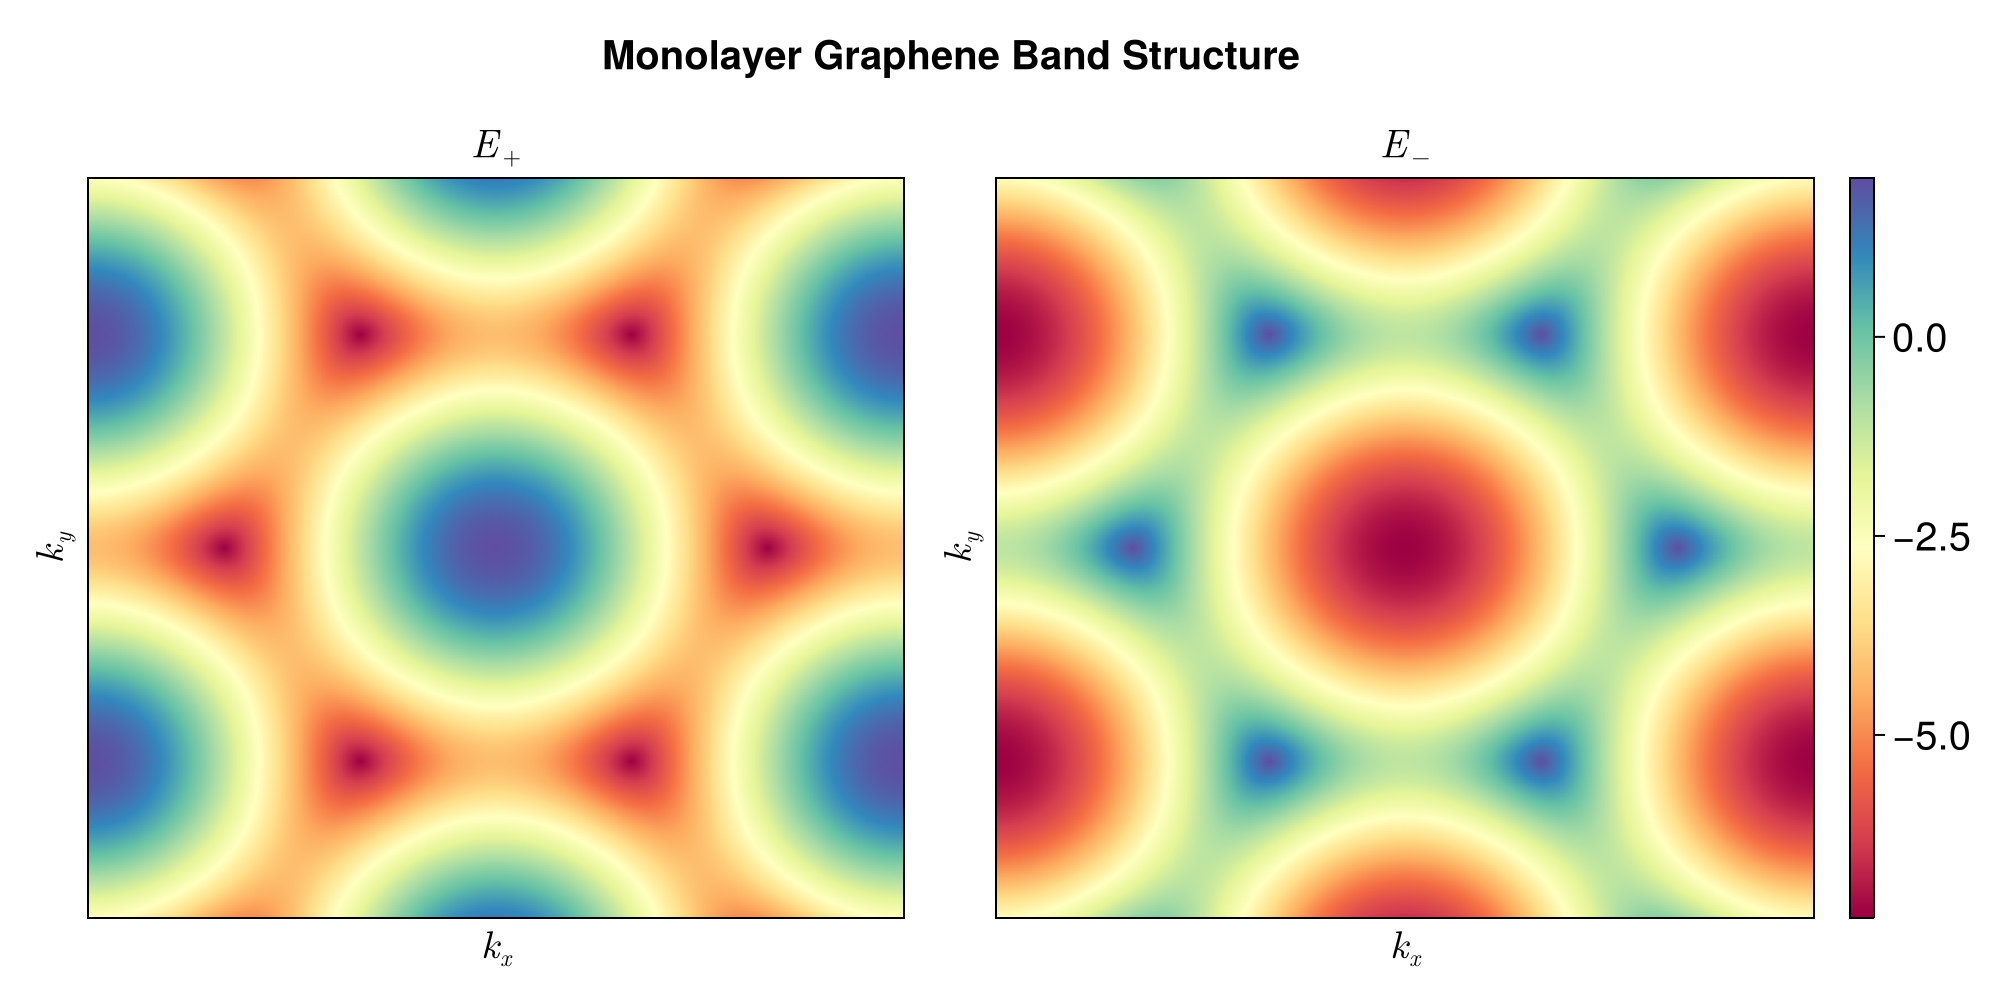

In [12]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)

# create and configure axes
ax_plus = Axis(P[1, 1], title = L"E_+", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_plus, label = false)
ax_minus = Axis(P[1, 2], title = L"E_-", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_minus, label = false)
ax_major = Axis(P[:, :], title = "Monolayer Graphene Band Structure", titlegap = 50)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

#plot dispersions
heatmap!(ax_plus, k_range, k_range, K_temp_vals[:, :, 2], colormap = :Spectral)
heatmap!(ax_minus, k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)
X, ax, tr = heatmap(k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)

#create and configure the colorbar
cb = Colorbar(P[1, 3], tr)
P

Evidently the Hamiltonian creation and diagonalization appears to be working (at least for $N_l = 1$), so we will proceed with the analysis of RMG

<font size="12">RMG Band Structure</font>

In [14]:
# Increase layer number
Nl = 3
# These vectors will be useful for computing energies at high-symmetry (K and K') points
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 2*pi/a * 2/sqrt(3)]
K = (2/3) * G1 + (1/3) * G2
Kp = (1/3) * G1 + (2/3) * G2

2-element Vector{Float64}:
 2.0943951023931953
 3.6275987284684357

- $G_1 = \frac{2 \pi}{a} \left(1, - \frac{1}{\sqrt{3}}\right)$ and $G_2 = \frac{2 \pi}{a} \left(0, \frac{2}{\sqrt{3}}\right)$ are reciprocal lattice basis vectors
- $K = \frac{2}{3} G_1 + \frac{1}{3} G_2$ and $K^\prime = \frac{1}{3} G_1 + \frac{2}{3} G_2$ are Dirac points

In [15]:
# Want to get dispersions around K point
K_eigenvals = Array{Float64}(undef, samps, 2 * Nl)
for i in 1:samps
    kx = k_range[i]
    ky = K[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    K_eigenvals[i, :] = real(vals)
end
# Want to get dispersions around K' point
Kp_eigenvals = Array{Float64}(undef, samps, 2 * Nl)

for i in 1:samps
    kx = k_range[i]
    ky = Kp[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    Kp_eigenvals[i, :] = real(vals)
end

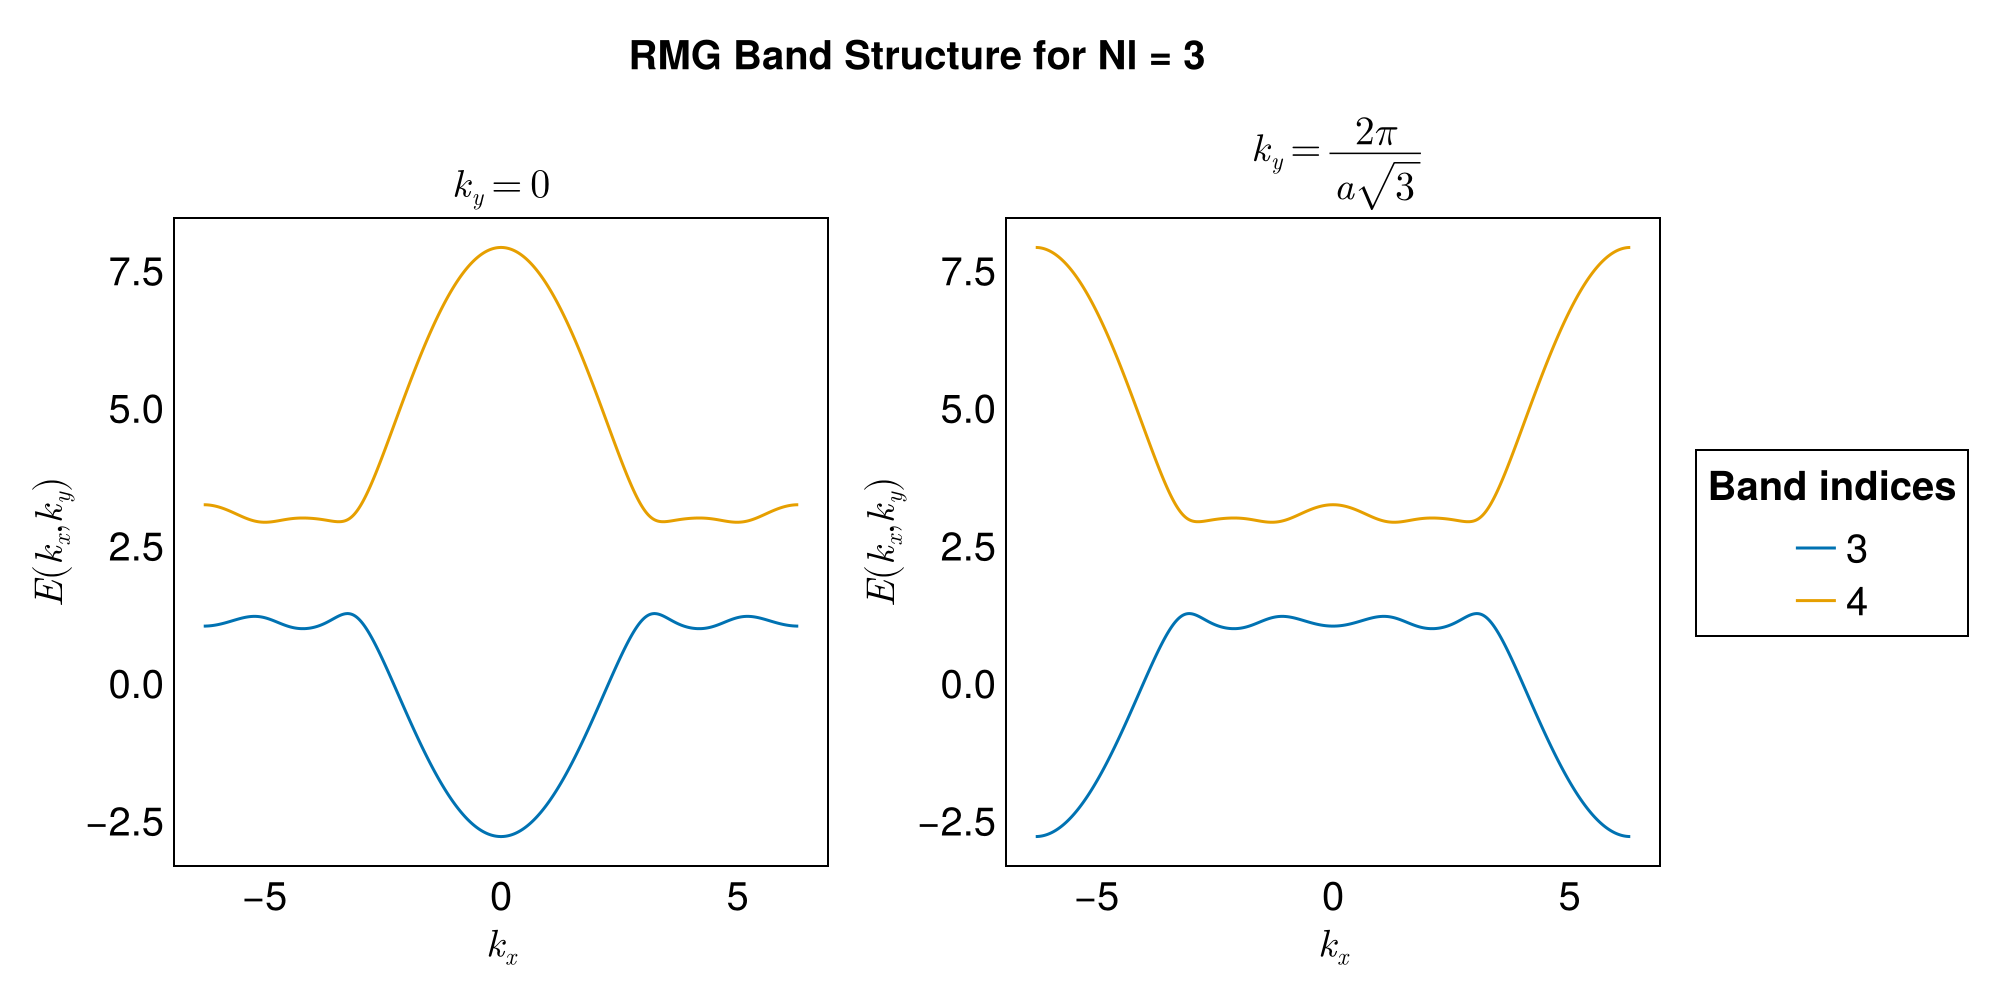

In [16]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax_k = Axis(P[1, 1], title = L"k_y = 0", xlabel = L"k_x", ylabel = L"E(k_x, k_y)")
hidedecorations!(ax_k, label = false, ticklabels = false)
ax_kp = Axis(P[1, 2], title = L"k_y = \frac{2 \pi}{a \sqrt{3}}", xlabel = L"k_x", ylabel = L"E(k_x, k_y)")
hidedecorations!(ax_kp, label = false, ticklabels = false)
ax_major = Axis(P[:, :], title = string("RMG Band Structure for Nl = ", string(Nl)), titlegap = 70)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

# plot bands
for i in Nl:(Nl + 1)
    lines!(ax_k, k_range, K_eigenvals[:, i], label = string(i))
    lines!(ax_kp, k_range, Kp_eigenvals[:, i], label = string(i))
end

# create and configure legend
P[1, 3] = Legend(P, ax_k, "Band indices", framevisible = true)
P

<font size="12">RMG Berry Curvature</font>

In [17]:
# pd is point-density
pd = 100
# lims for 1 unit cell
uc_xlim = 4*pi/a
uc_ylim = uc_xlim * sqrt(3) / 2
# dimension of unit cell patchwork (n_cell x n_cell)
n_cell = 5
# dimensions of the enlarged k-space cell
xlim = n_cell * uc_xlim
ylim = n_cell * uc_ylim
uD = 10

10

There are a few important notes to make here. 
- We discretize a single unit cell into a parallelogram of ${pd}^2$ points in k-space.
- To observe interesting features of Berry curvature near Dirac points, we must compute the Berry curvature $> 1$ (${n_{cell}}^2$) unit cells. 
- Then we appropriately set the $x$ and $y$ limits ($xlim, ylim$) to ensure that the resulting patchwork of unit cells is still a parallelogram (this doesn't matter too much).

In [18]:
# This generates a line of points in K-space
function gen_list(xlim, n, shift, y)
    x_vals = range(-xlim + shift, shift, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end
# This generates a single unit cell of points in K-space
function gen_grid(xlim, n)
    step = range(0, xlim, n)
    grid = Array{Float64}(undef, n, n, 2)
    for i in 1:n
        grid[:, i, :] = gen_list(xlim, n, 0.5*step[i], (sqrt(3)/2)*step[i])
    end
    return grid
end
# Shift a grid over
function shift_grid(grid, n, xshift, yshift)
    new_grid = copy(grid)
    for i in 1:n
        new_grid[:, i, 2] += yshift * ones(size(grid[:, i, 2]))
        new_grid[:, i, 1] += xshift * ones(size(grid[:, i, 1]))
    end
    return new_grid
end

shift_grid (generic function with 1 method)

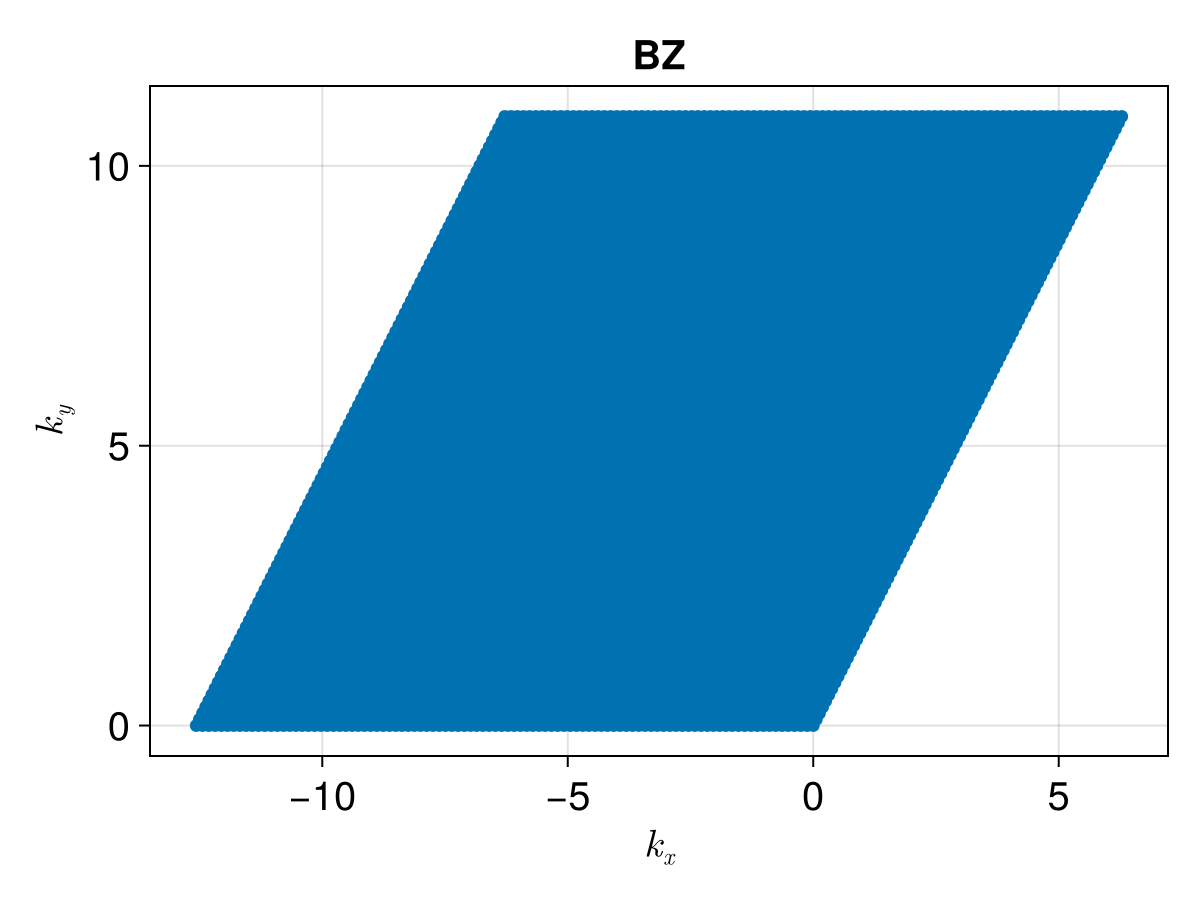

In [19]:
# Sample unit cell in k-space
uc_k_grid = gen_grid(uc_xlim, pd)
# uc_k_grid = shift_grid(uc_k_grid, pd, xlim, ylim)
uc_k_mesh = reshape(uc_k_grid, (pd^2, 2))
P = Figure(fontsize = 20)
ax_major = Axis(P[:, :], title = "BZ", xlabel = L"$k_x$", ylabel = L"$k_y$")
scatter!(ax_major, uc_k_mesh[:, 1], uc_k_mesh[:, 2])
P

This parallelogram is still a valid Brillouin zone because it is formed by connecting the centers of $4$ hexagons in k-space (which forms a Brillouin zone). The reason we use a parallelogram unit cell over a hexagonal unit cell is because there are Dirac points contained within the parallelogram, so it is easier to see unique Berry curvature behavior using this unit cell.

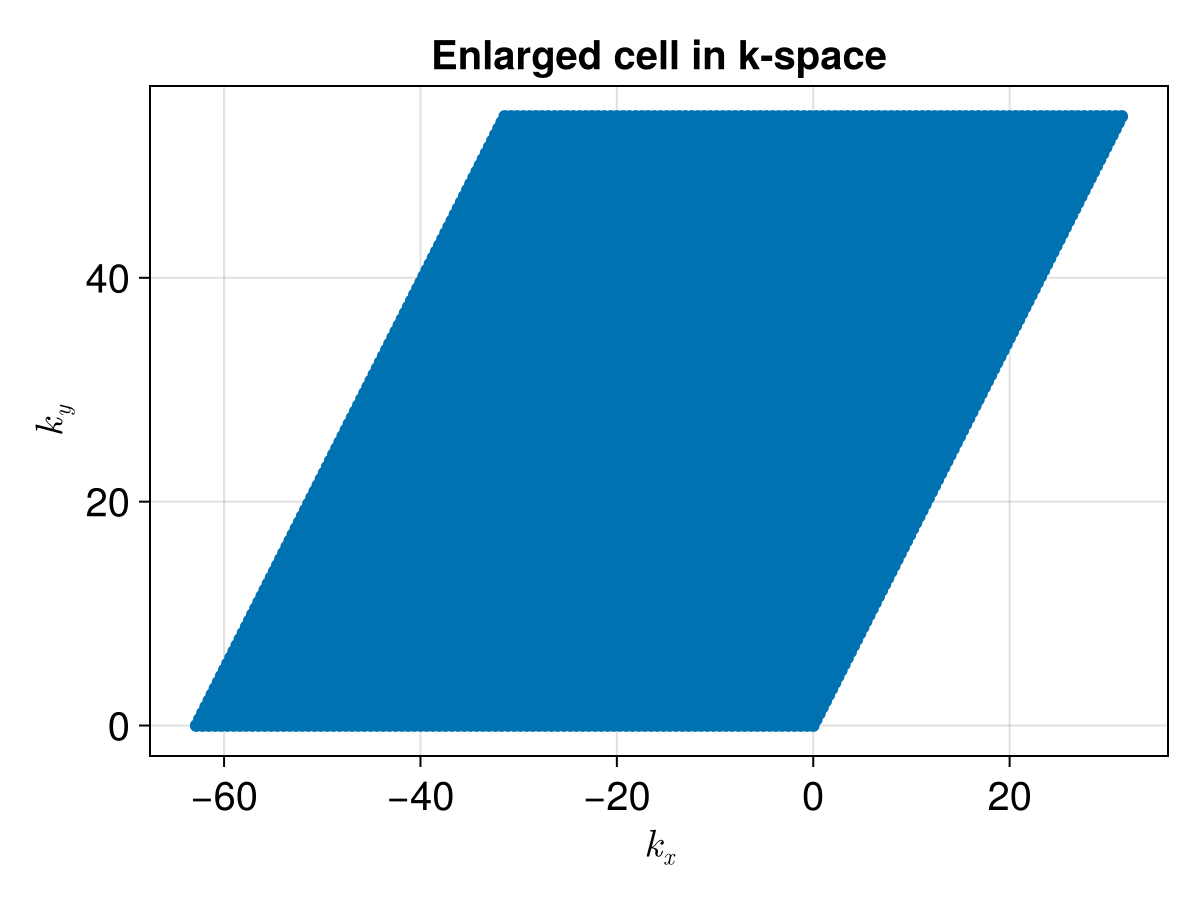

In [20]:
# Enlarged cell in k-space
k_grid = gen_grid(n_cell*uc_xlim, pd)
k_mesh = reshape(k_grid, (pd^2, 2))
P = Figure(fontsize = 20)
ax_major = Axis(P[:, :], title = "Enlarged cell in k-space", xlabel = L"$k_x$", ylabel = L"$k_y$")
scatter!(ax_major, k_mesh[:, 1], k_mesh[:, 2])
P

An important note regarding this discretization of k-space is that increasing $n_{cell}$ does not make the lattice finer. In contrast, it actually makes the lattice coarser since we now spread the same number of points across a larger region. So typically, when we increase $n_{cell}$ we will also have to increase $pd$ to ensure that the quality of the discrete Brillouin zone does not deteriorate too much.

Now we compute the Berry curvature according to the following method. This method provides a gauge-invariant computation of the Berry curvature for a discrete Brillouin zone. 
- Suppose $\psi_k^{l}$ is the wave-function for the $l^{\text{th}}$ band.
- Define $e^{i\theta_{12}}_l = \frac{\langle \psi_{k2}^l | \psi_{k1}^l \rangle}{| \langle \psi_{k2}^l | \psi_{k1}^l \rangle|}$
- Then we can compute the Berry flux through a plaquette with corners represented by points (1, 2, 3, 4) as 
$\Phi_{1234}^l = arg(e^{i\theta_{21}}_l e^{i\theta_{32}}_l e^{i\theta_{43}}_l e^{i\theta_{14}}_l)$
- Here we define the Berry curvature as $B_z^l (k) = A * \Phi_{1234}^l$ where $A$ is the area of the plaquette. In our actual computation we don't account for the area because it's just a proportionality factor.
- Then using this definition of the Berry curvature, we can compute the Chern number of a band as 
$C^l = \frac{1}{2 \pi} \int_{BZ} dk B^l_z (k)$ 
    - Here $\int_{BZ}$ is an integral over the Brillouin zone.

In [21]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec(l, kx, ky, a, uD, t0, t1, t2, t3, t4, Nl)
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vecs = eigvecs(Hermitian(ham))
    return vecs[:, l]
end

eigen_vec (generic function with 1 method)

In [22]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta(l, x1, y1, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl)
    ev1 = eigen_vec(l, x1, y1, a, uD, t0, t1, t2, t3, t4, Nl)
    ev2 = eigen_vec(l, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta (generic function with 1 method)

In [23]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux(l, x1, y1, x2, y2, x3, y3, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl)
    big_theta = theta(l, x2, y2, x1, y1, a, uD, t0, t1, t2, t3, t4, Nl) *
        theta(l, x3, y3, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl) * theta(l, x4, y4, x3, y3, a, uD, t0, t1, t2, t3, t4, Nl) * 
    theta(l, x1, y1, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux (generic function with 1 method)

In [58]:
# Berry curvature over all plaquettes
function berry_curvature(l, points, n, a, uD, t0, t1, t2, t3, t4, Nl)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            curvature = -flux(l, x1, y1, x2, y2, x3, y3, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature (generic function with 1 method)

In [59]:
# Berry curvature over all plaquettes
function berry_curvature_2(l, points, n, a, uD, t0, t1, t2, t3, t4, Nl, xlim)
    berry_list = Array{Float64}(undef, n^2)
    for i in 1:n^2
        # get flux through plaquette centered at point
        angles = Array{Float64}(undef, 4)
        square = Array{Float64}(undef, length(angles), 2)
        x0 = points[i, 1]
        y0 = points[i, 2]
        spacing = 10^(-1) * xlim/n
        for j in 1:length(angles)
            square[j, 1] = x0 + spacing * cos(2 * pi * (j - 1) / length(angles))
            square[j, 2] = y0 + spacing * sin(2 * pi * (j - 1) / length(angles))
        end
        berry_list[i] = -flux(l, square[1, 1], square[1, 2], square[2, 1], square[2, 2], square[3, 1], square[3, 2], square[4, 1], square[4, 2], 
        a, uD, t0, t1, t2, t3, t4, Nl)
    end
    return berry_list
end

berry_curvature_2 (generic function with 2 methods)

In [60]:
# Get berry curvature for all bands
@time begin
flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
for l in 1:2*Nl
    temp_flux, akx, aky = berry_curvature(l, k_grid, pd, a, uD, t0, t1, t2, t3, t4, Nl)
    uc_temp_flux, trash, trash = berry_curvature(l, uc_k_grid, pd, a, uD, t0, t1, t2, t3, t4, Nl)
    uc_flux_list[l, :] = uc_temp_flux
    flux_list[l, :] = temp_flux
    kx_avg_list[l, :] = akx
    ky_avg_list[l, :] = aky
end
end

  9.547978 seconds (37.73 M allocations: 16.213 GiB, 19.68% gc time, 0.75% compilation time)


In [61]:
# Get berry curvature for all bands
new_pts = Array{Float64}(undef, 2*Nl, pd^2, 2)
@time begin
    flux_list_2 = Array{Float64}(undef, 2*Nl, pd^2)
    for l in 1:2*Nl
        flux_list_2[l, :] = berry_curvature_2(l, uc_k_mesh, pd, a, uD, t0, t1, t2, t3, t4, Nl, uc_xlim)
        new_pts[l, :, :] = uc_k_mesh
    end
end

  4.377063 seconds (19.33 M allocations: 8.275 GiB, 12.68% gc time, 0.31% compilation time)


In [62]:
# Compute the Chern numbers of each band
chern_numbers = Array{Float64}(undef, 2*Nl)
for l in 1:2*Nl
    chern_numbers[l] = sum(uc_flux_list[l, :]) / (2 * pi)
end
@show chern_numbers

chern_numbers = [2.161783260057234e-16, -3.103249532955723e-16, -6.350065770283063e-16, -1.1595772276169071e-15, -8.901135671040259e-16, -9.514055062780624e-16]


6-element Vector{Float64}:
  2.161783260057234e-16
 -3.103249532955723e-16
 -6.350065770283063e-16
 -1.1595772276169071e-15
 -8.901135671040259e-16
 -9.514055062780624e-16

In [63]:
# Plot the Berry curvatures for each band over the enlarged cell
function plot_berry(fig, kx_list, ky_list, fluxes, Nl)
    for i in 1:2
        for j in 1:Nl
            index = (i - 1) * Nl + j
            t_string = "l = "*string(index)
            ax = Axis(fig[j, i], title = t_string)
            hidedecorations!(ax)
            tricontourf!(ax, kx_list[index, :], ky_list[index, :], fluxes[index, :], colormap = :Spectral)
        end
    end
    X, ax, tr = tricontourf(kx_list[1, :], ky_list[1, :], fluxes[1, :], colormap = :Spectral)
    cb = Colorbar(fig[1:Nl, 3], tr)
    ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
    hidedecorations!(ax, label = false)
    hidespines!(ax)
    fig
end

plot_berry (generic function with 1 method)

  9.010685 seconds (9.72 M allocations: 539.588 MiB, 0.75% gc time, 0.41% compilation time)


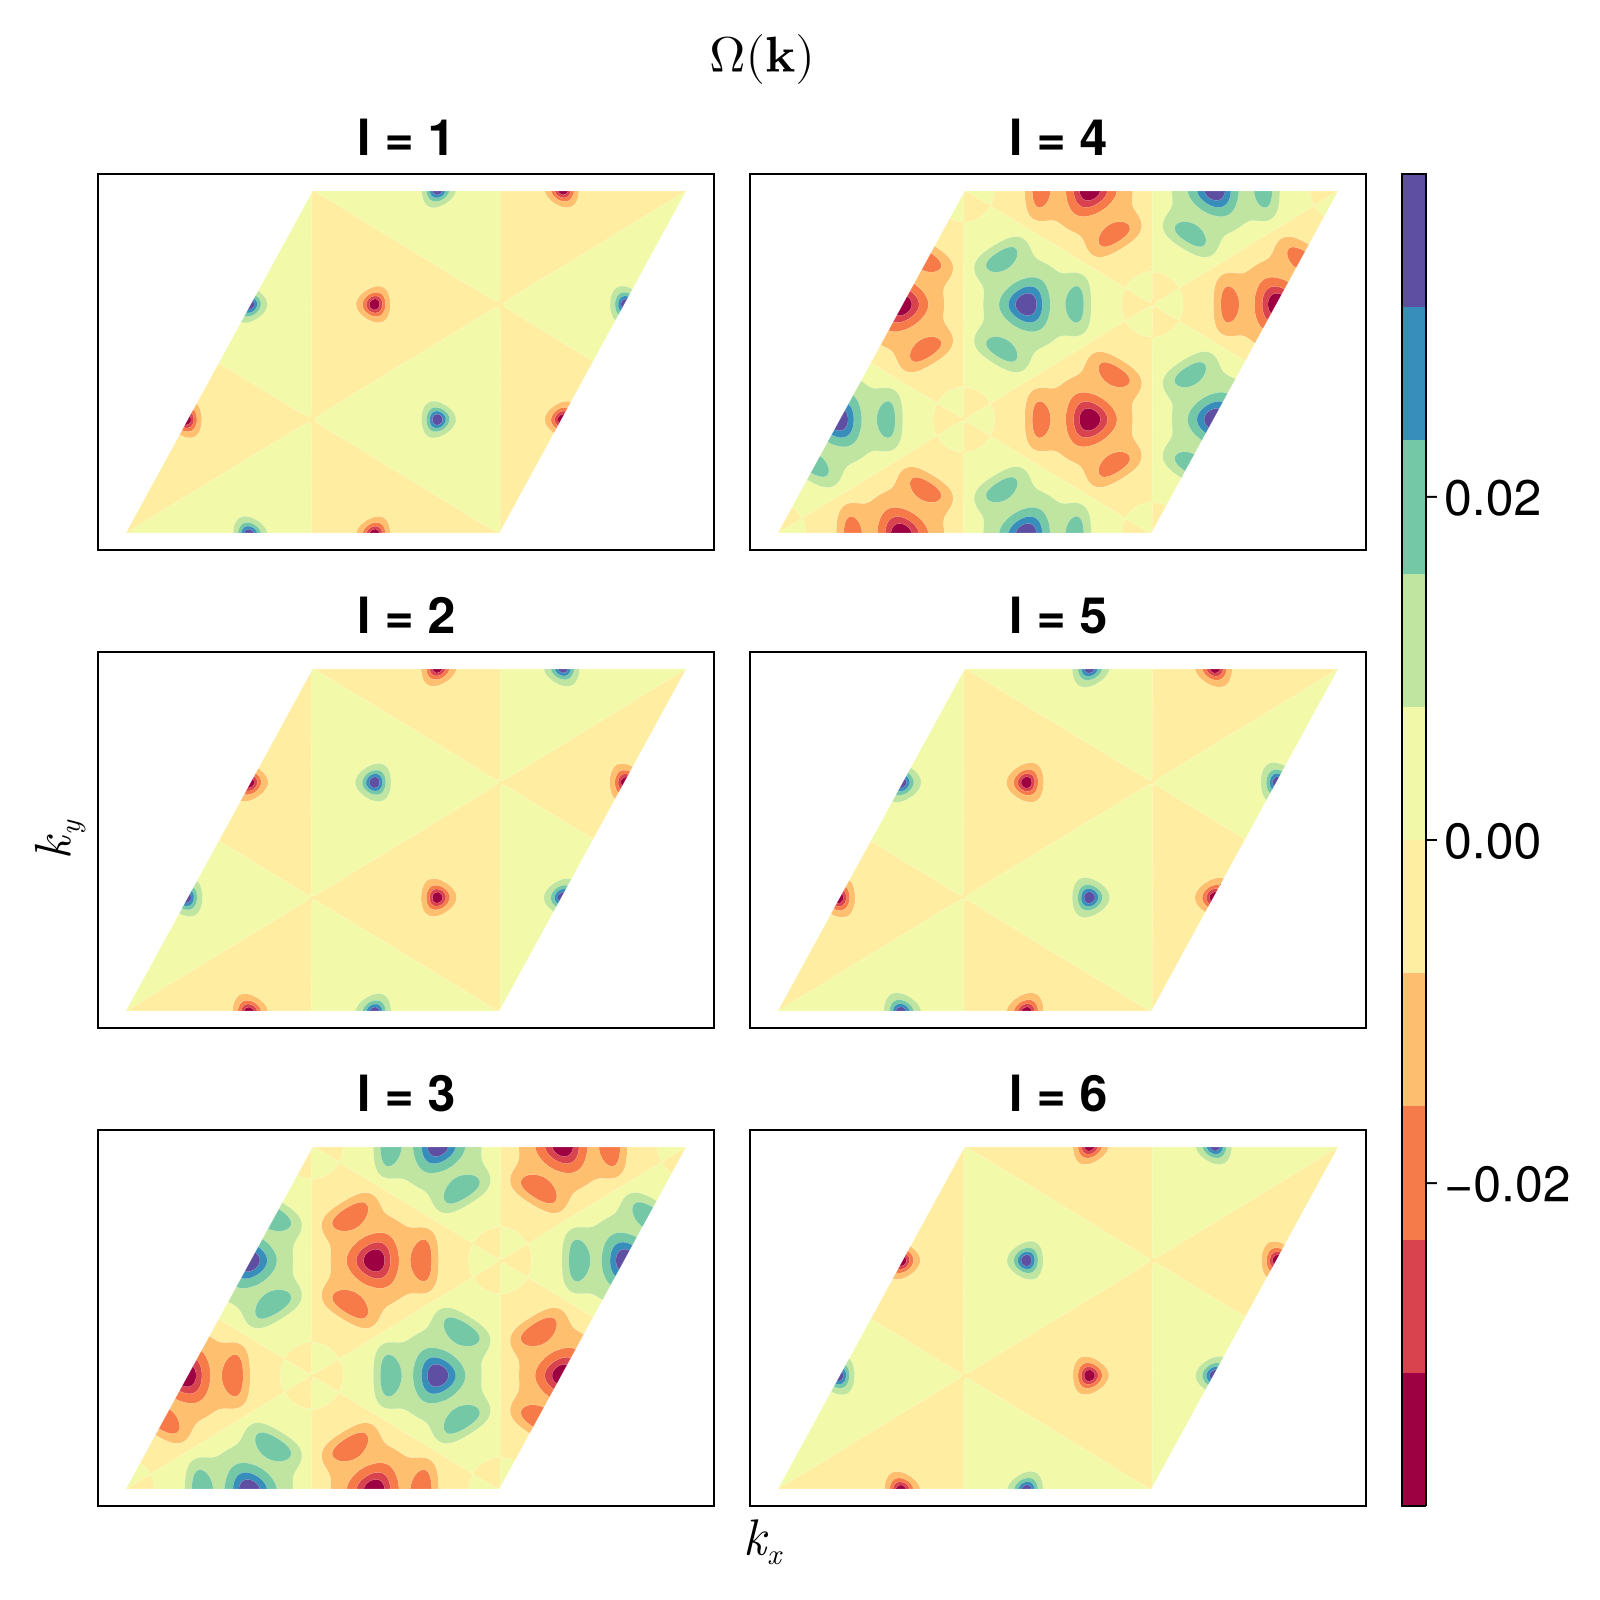

In [64]:
@time begin
berry_fig = Figure(size=(800, 800), fontsize=25)
plot_berry(berry_fig, kx_avg_list, ky_avg_list, uc_flux_list, Nl)
end

  9.643945 seconds (12.19 M allocations: 603.845 MiB, 2.87% gc time, 0.00% compilation time)


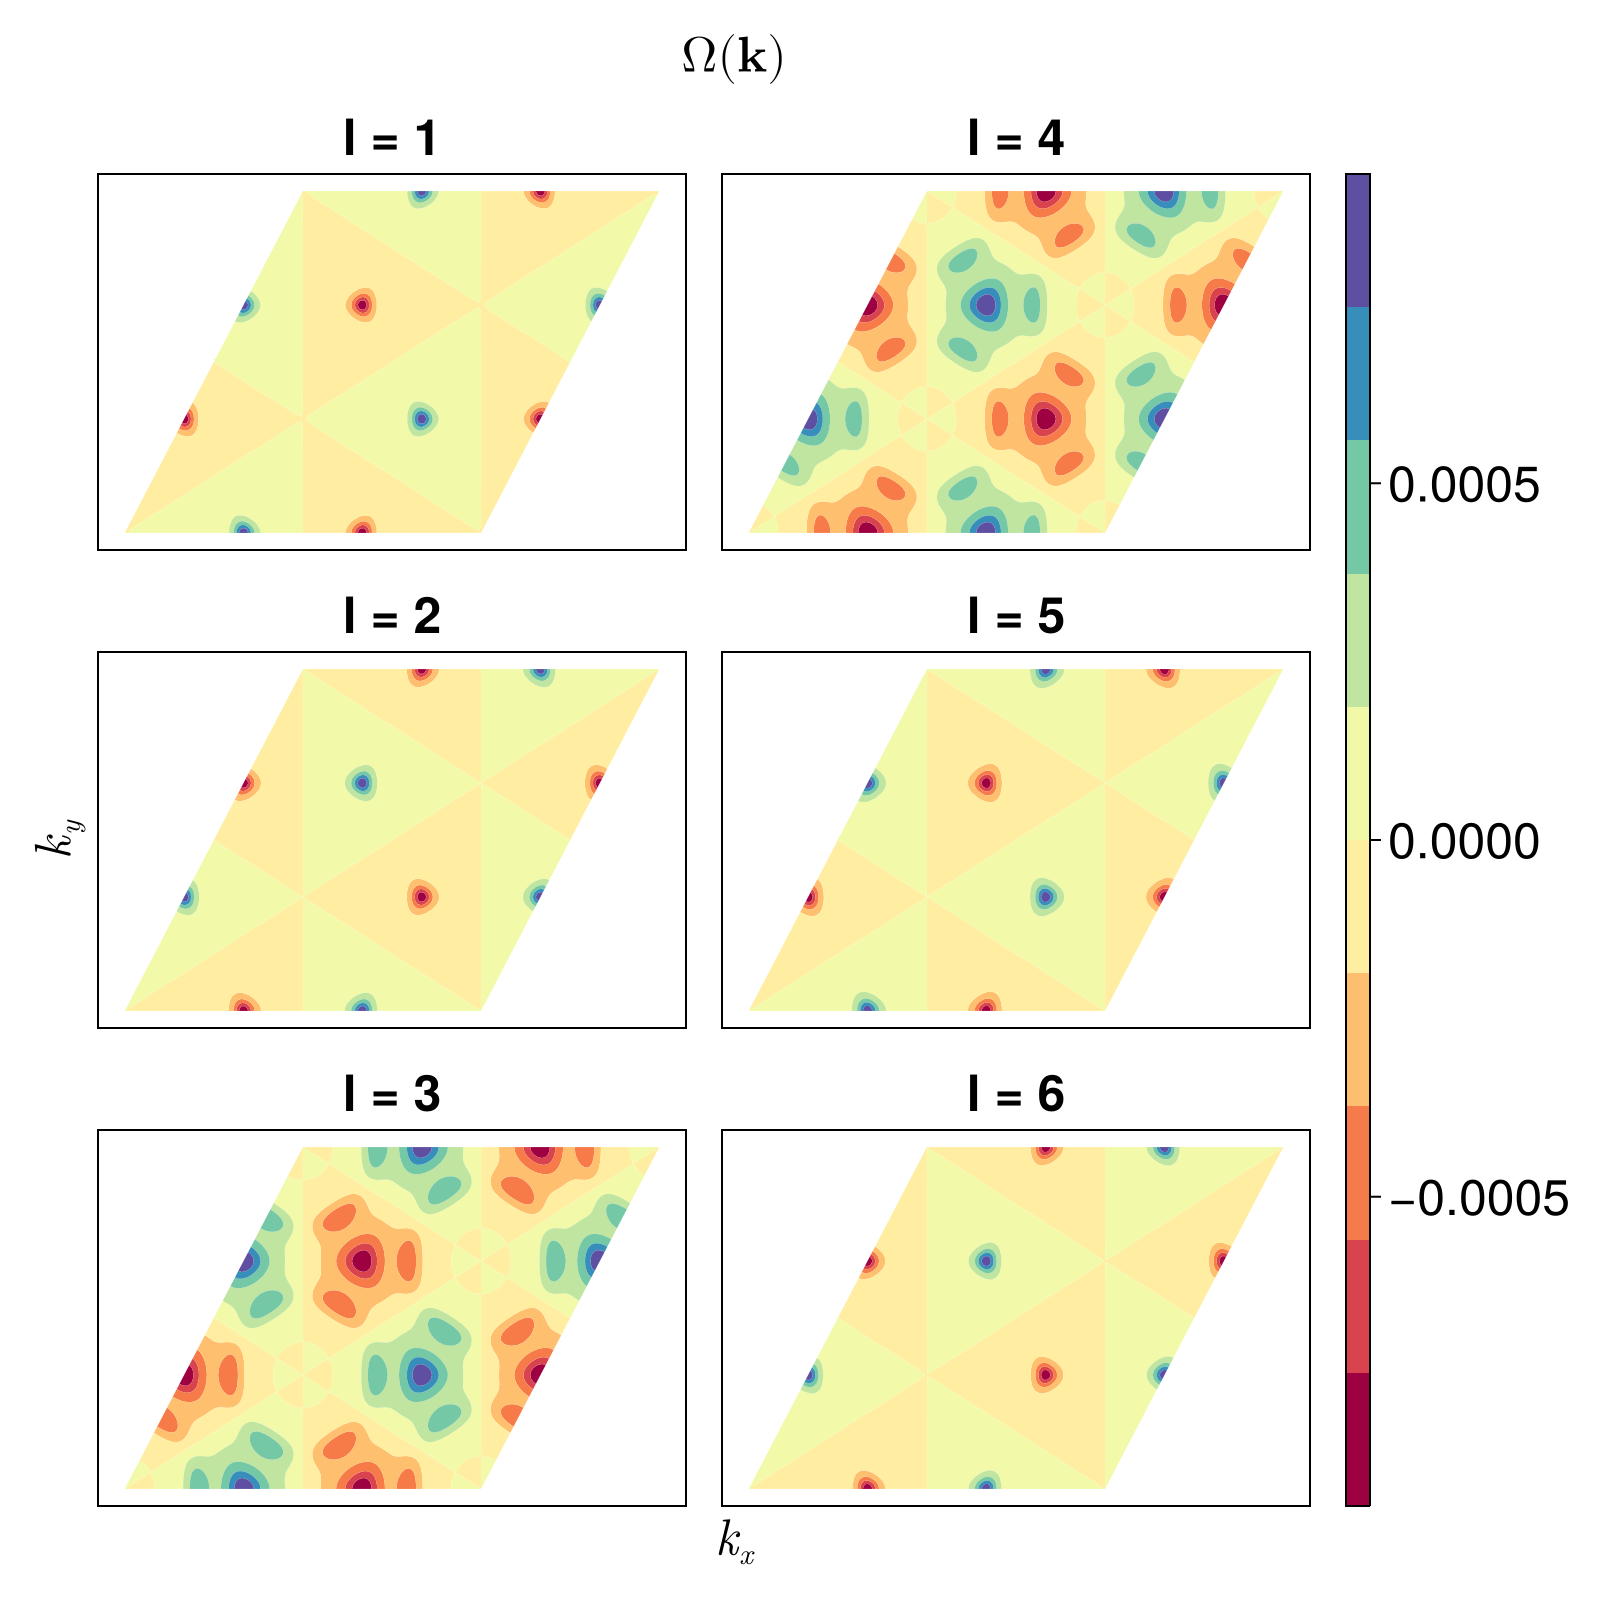

In [65]:
@time begin
    berry_fig = Figure(size=(800, 800), fontsize=25)
    plot_berry(berry_fig, new_pts[:, :, 1], new_pts[:, :, 2], flux_list_2, Nl)
    end

<font size="12">Berry Curvature @ K</font>

In [66]:
# Fix Nl = 3
Nl = 3
# fix other sample parameters
uD = 100
pd = 100
rad = 0.1

0.1

In [67]:
# This generates a line of points in K-space
function make_line(x0, x1, n, y)
    x_vals = range(x0, x1, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end

# draw a square around k of dimensions radius x radius (with point-density n)
function k_zone(k, n, radius)
    kx = k[1]
    ky = k[2]
    grid = Array{Float64}(undef, n, n, 2)
    ky_pts = range(ky - radius/2, ky + radius/2, n)
    for i in 1:n
        grid[:, i, :] = make_line(kx - radius/2, kx + radius/2, n, ky_pts[i])
    end
    return grid
end

k_zone (generic function with 1 method)

In [68]:
# explore a small region around K point
Kpt_grid = k_zone(K, pd, rad)

100×100×2 Array{Float64, 3}:
[:, :, 1] =
 4.13879  4.13879  4.13879  4.13879  …  4.13879  4.13879  4.13879  4.13879
 4.1398   4.1398   4.1398   4.1398      4.1398   4.1398   4.1398   4.1398
 4.14081  4.14081  4.14081  4.14081     4.14081  4.14081  4.14081  4.14081
 4.14182  4.14182  4.14182  4.14182     4.14182  4.14182  4.14182  4.14182
 4.14283  4.14283  4.14283  4.14283     4.14283  4.14283  4.14283  4.14283
 4.14384  4.14384  4.14384  4.14384  …  4.14384  4.14384  4.14384  4.14384
 4.14485  4.14485  4.14485  4.14485     4.14485  4.14485  4.14485  4.14485
 4.14586  4.14586  4.14586  4.14586     4.14586  4.14586  4.14586  4.14586
 4.14687  4.14687  4.14687  4.14687     4.14687  4.14687  4.14687  4.14687
 4.14788  4.14788  4.14788  4.14788     4.14788  4.14788  4.14788  4.14788
 ⋮                                   ⋱                             
 4.23071  4.23071  4.23071  4.23071     4.23071  4.23071  4.23071  4.23071
 4.23172  4.23172  4.23172  4.23172     4.23172  4.23172  4.23172  

In [69]:
# Get berry curvature for all bands
@time begin
flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
for l in 1:2*Nl
    temp_flux, akx, aky = berry_curvature(l, Kpt_grid, pd, a, uD, t0, t1, t2, t3, t4, Nl)
    flux_list[l, :] = temp_flux
    kx_avg_list[l, :] = akx
    ky_avg_list[l, :] = aky
end
end

  4.257745 seconds (18.82 M allocations: 8.104 GiB, 14.04% gc time)


  4.110593 seconds (9.46 M allocations: 394.195 MiB, 0.96% gc time, 0.65% compilation time)


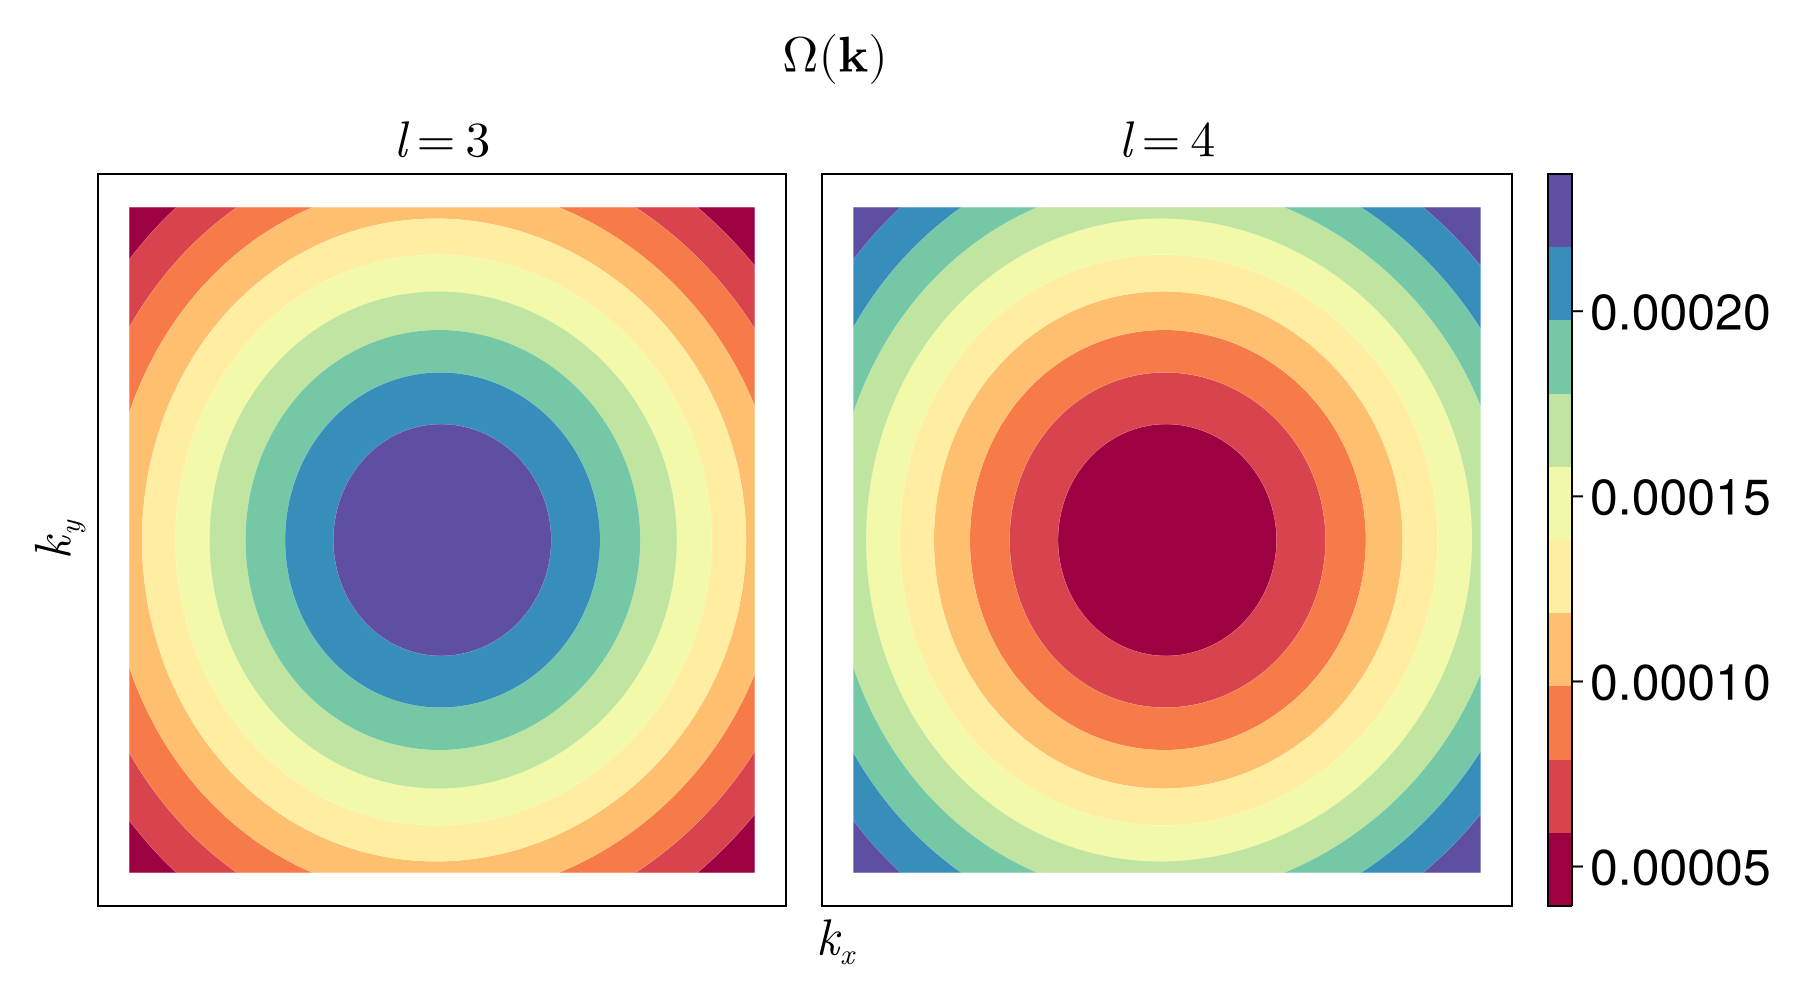

In [70]:
# plot Berry curvature just for l = 3,4 bands
@time begin
fig = Figure(size=(900, 500), fontsize=25)
    
t_string = L"l = 3"
ax = Axis(fig[1, 1], title = t_string)
hidedecorations!(ax)
tricontourf!(ax, kx_avg_list[3, :], ky_avg_list[3, :], flux_list[3, :], colormap = :Spectral)

t_string = L"l = 4"
ax = Axis(fig[1, 2], title = t_string)
hidedecorations!(ax)
tricontourf!(ax, kx_avg_list[4, :], ky_avg_list[4, :], flux_list[4, :], colormap = :Spectral)

X, ax, tr = tricontourf(kx_avg_list[1, :], ky_avg_list[1, :], flux_list[1, :], colormap = :Spectral)
cb = Colorbar(fig[1, 3], tr)
ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
hidedecorations!(ax, label = false)
hidespines!(ax)
fig
    
end

Around the k-point, this is what $\Omega (k)$ looks like. Then what we are going to do is calculate the Berry curvature in a small region aroung the $K$ point for varying $u_D$. Then we fix $k_y = 0$ and consider only a line $\Omega (k_x, k_y = 0)$. We will plot this quantity for several values of $u_D$.

In [71]:
# study for varying values of uD
uD_samps = 20
uD_list = range(-50, 50, uD_samps)

-50.0:5.2631578947368425:50.0

In [72]:
uD_flux_list = Array{Float64}(undef, uD_samps, 2, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, uD_samps, 2, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, uD_samps, 2, (pd - 1)^2)
for s in 1:uD_samps
    @time begin
    temp_flux, akx, aky = berry_curvature(3, Kpt_grid, pd, a, uD_list[s], t0, t1, t2, t3, t4, Nl)
    uD_flux_list[s, 1, :] = temp_flux
    kx_avg_list[s, 1, :] = akx
    ky_avg_list[s, 1, :] = aky
    temp_flux, akx, aky = berry_curvature(4, Kpt_grid, pd, a, uD_list[s], t0, t1, t2, t3, t4, Nl)
    uD_flux_list[s, 2, :] = temp_flux
    kx_avg_list[s, 2, :] = akx
    ky_avg_list[s, 2, :] = aky
    end
end

  1.540268 seconds (6.34 M allocations: 2.705 GiB, 14.15% gc time, 3.83% compilation time)
  1.438415 seconds (6.27 M allocations: 2.701 GiB, 13.36% gc time)
  1.437770 seconds (6.27 M allocations: 2.701 GiB, 13.62% gc time)
  1.422392 seconds (6.27 M allocations: 2.701 GiB, 13.49% gc time)
  1.424825 seconds (6.27 M allocations: 2.701 GiB, 12.15% gc time)
  1.519021 seconds (6.27 M allocations: 2.701 GiB, 13.51% gc time)
  1.513512 seconds (6.27 M allocations: 2.701 GiB, 13.33% gc time)
  1.478270 seconds (6.27 M allocations: 2.701 GiB, 13.42% gc time)


InterruptException: InterruptException:

In [73]:
# keep only the line ky = 0
filtered_uD_fluxes = Array{Float64}(undef, uD_samps, 2, pd - 1)
filtered_akx = Array{Float64}(undef, uD_samps, 2, pd - 1)
for s in 1:uD_samps
    index = 1
    for i in 1:(pd - 1)^2
        if ky_avg_list[s, 1, i] == 0
            filtered_uD_fluxes[s, 1, index] = uD_flux_list[s, 1, i]
            filtered_uD_fluxes[s, 2, index] = uD_flux_list[s, 2, i]
            filtered_akx[s, 1, index] = kx_avg_list[s, 1, i]
            filtered_akx[s, 2, index] = kx_avg_list[s, 2, i]
            index += 1
        end
    end
end

BoundsError: BoundsError: attempt to access 20×2×99 Array{Float64, 3} at index [9, 1, 100]

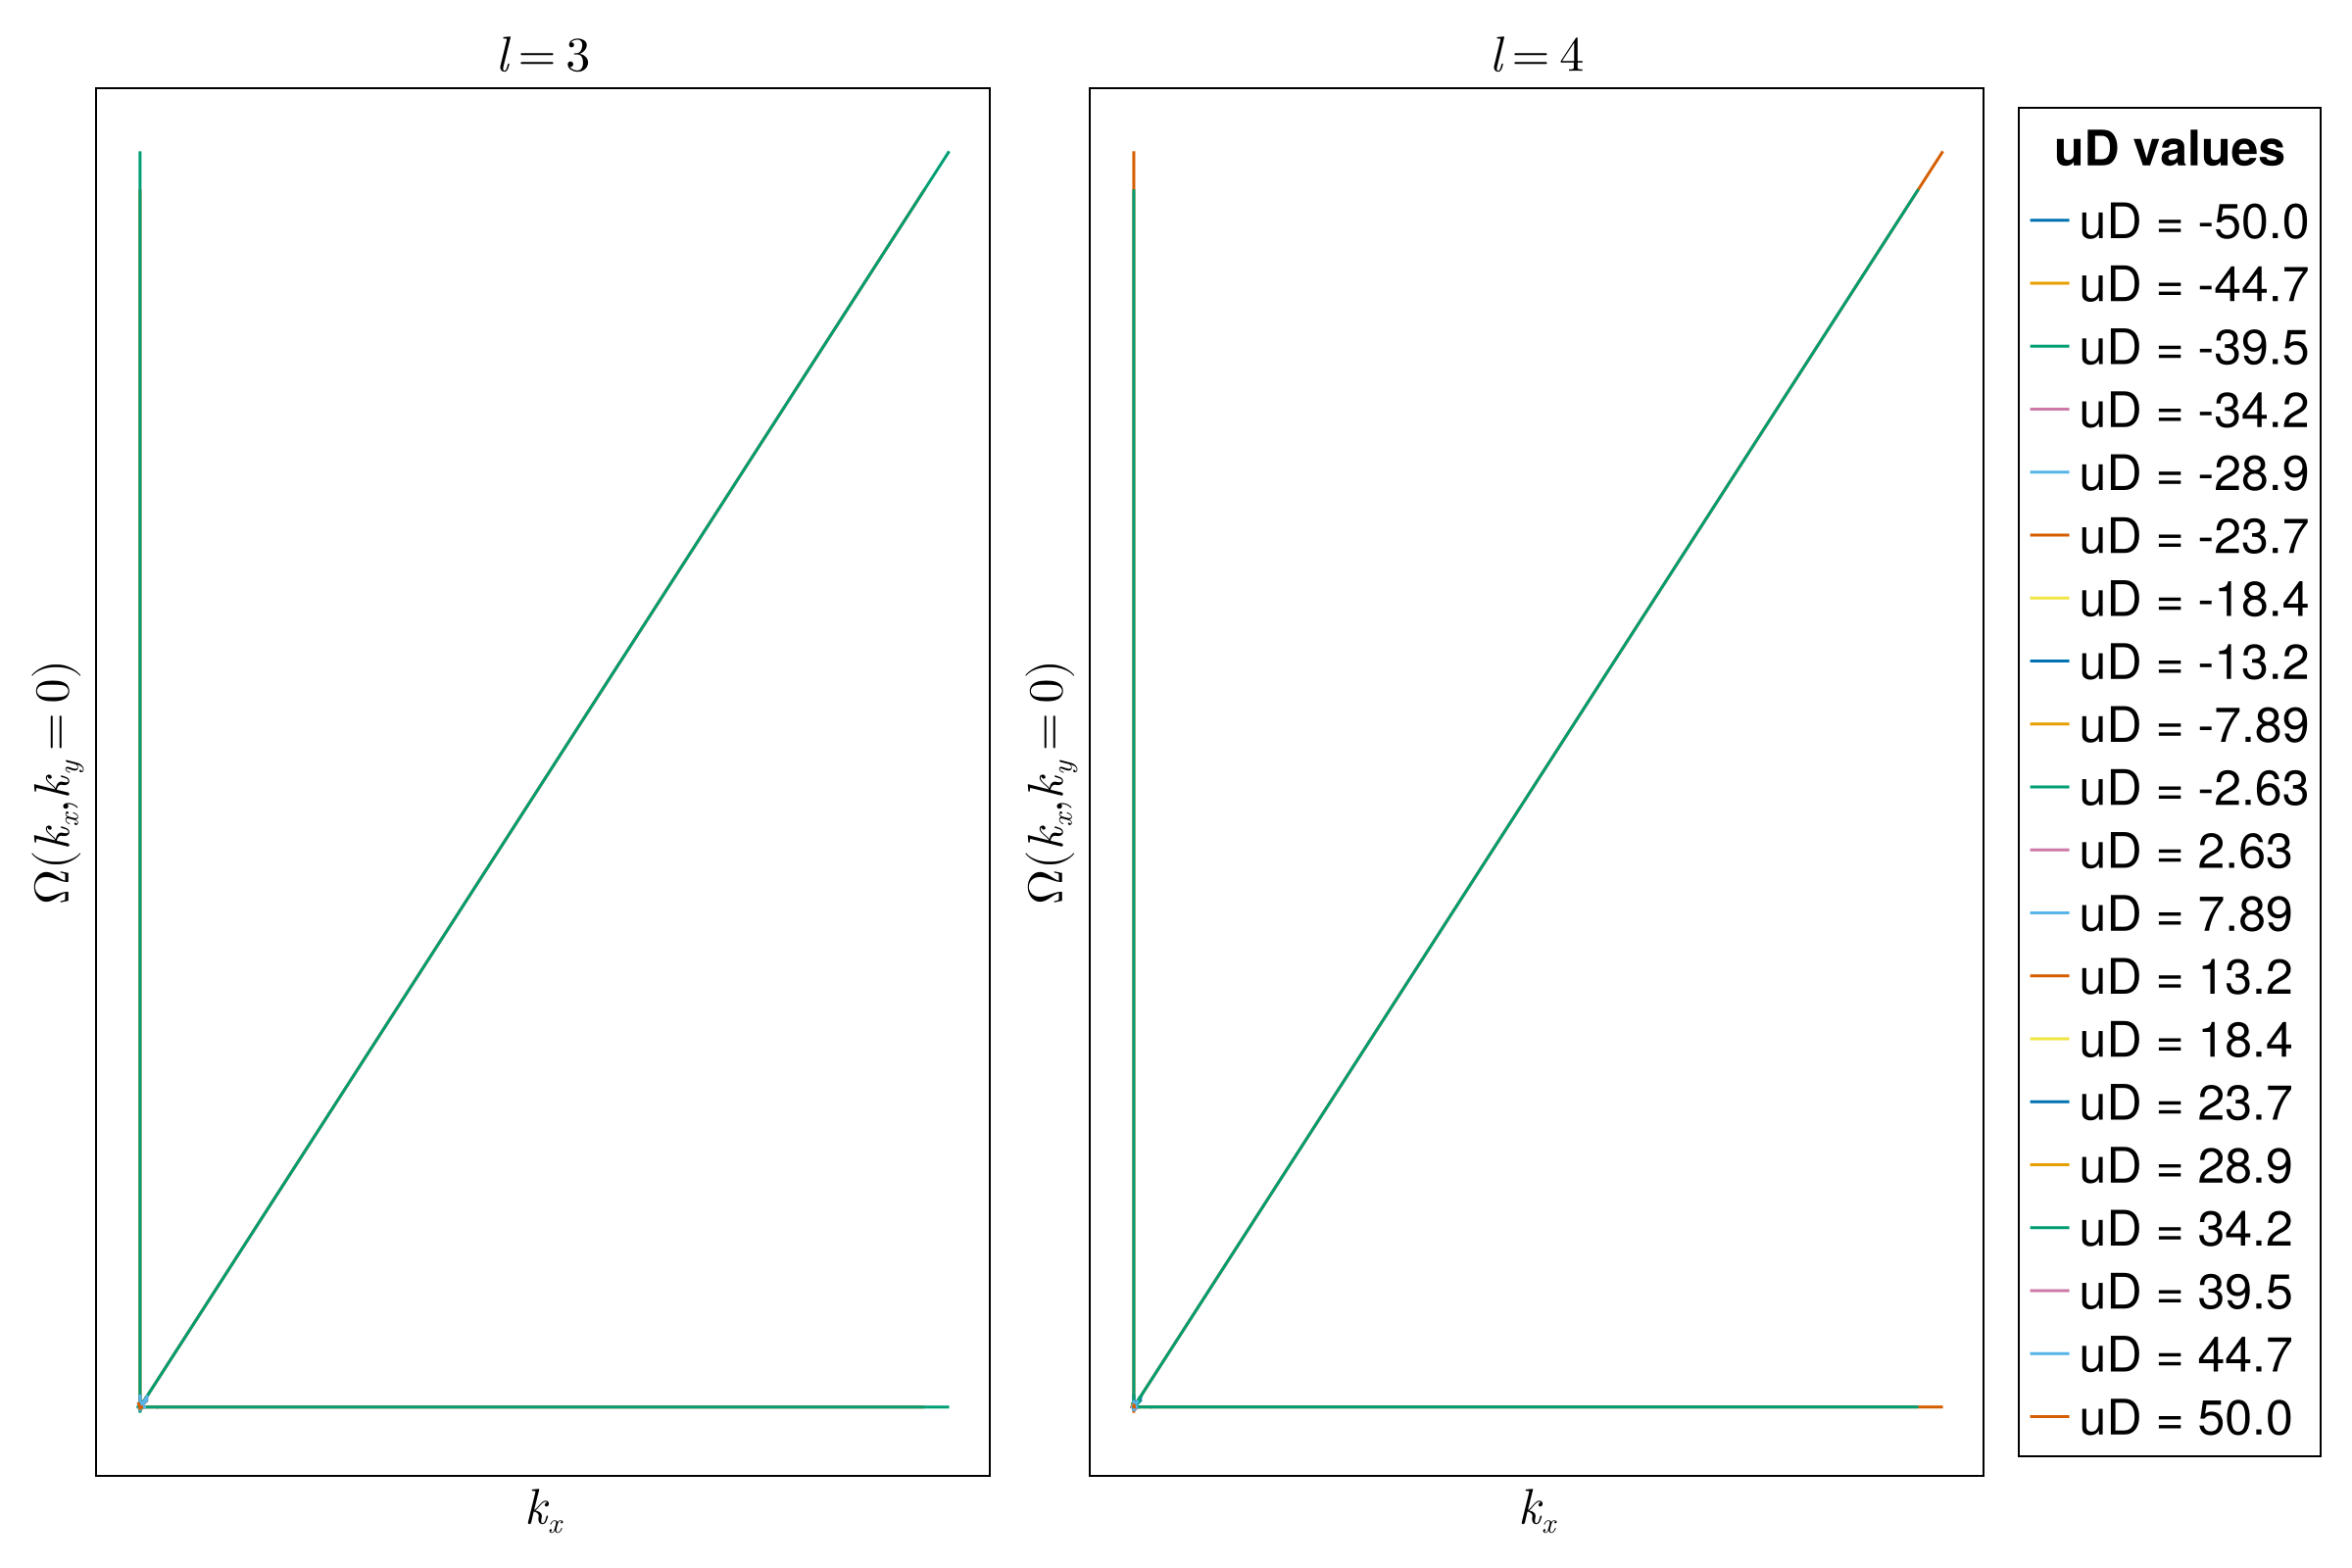

In [74]:
# Plot the l = 3, l = 4 berry curvatures for several values of uD across the line ky = 0
uD_fig = Figure(size=(1200, 800), fontsize=25)
ax3 = Axis(uD_fig[1, 1], title = L"l = 3", xlabel = L"k_x", ylabel = L"\Omega (k_x, k_y = 0)")
ax4 = Axis(uD_fig[1, 2], title = L"l = 4", xlabel = L"k_x", ylabel = L"\Omega (k_x, k_y = 0)")

for j in 1:uD_samps
    uD_val = round(uD_list[j], sigdigits = 3)
    lines!(ax3, filtered_akx[j, 1, :], filtered_uD_fluxes[j, 1, :], label = "uD = "*string(uD_val))
    lines!(ax4, filtered_akx[j, 2, :], filtered_uD_fluxes[j, 2, :], label = "uD = "*string(uD_val))
    hidedecorations!(ax3, label = false)
    hidedecorations!(ax4, label = false)
end
uD_fig[1, 3] = Legend(uD_fig, ax3, "uD values", framevisible = true)
uD_fig

Observe that $l = 3$ and $l = 4$ appear to have "inverse" Berry curvatures.

<font size="12">Adding Scalar Potential</font>

The scalar potential we consider is $V(r) = -V_0 \sum_{i = 1}^2 cos(\frac{1}{q}G_i \cdot r)$. Here $a^\prime = q * a$ is the super-lattice constant, and $G_i$ are the reciprocal lattice vectors. We assume that $V_0$ is small so that we can treat this super-lattice scalar potential using perturbation theory.

In Fourier space, the corresponding Bloch matrix of $V(r)$ is simply

\begin{equation}
V_K = \sum_{j = 1}^{N_l} 
V_K^{(q)} \otimes I_j
\end{equation}
where
\begin{equation}
V_K^{(q)} = 
\begin{bmatrix}
    0 & V_0^* & 0 \\
    V_0 & 0 & V_0^* & 0 \\
    0 & V_0 & 0 & \ddots & \ddots \\
    & 0 & \ddots & \ddots & V_0^* & 0 \\
    & & \ddots & V_0 & 0 & V_0^* \\
    & & & 0 & V_0 & 0
    \end{bmatrix}
\end{equation}
is a $2q \times 2q$ matrix
- In this case, the unit-cell will be enlarged to a $q \times q$ super-cell of original unit cells.
- This will shrink the Brillouin Zone by a factor of $q^2$, so we must fold the cell into a smaller hexagon.

Now let's compute $\Omega(k)$ in the vicinity of the Dirac points of the BZ and folded BZ. Here we use $q = 2$. To do this we linearize the RMG Hamiltonian in the vicinity of the Dirac points.

Notes:
- The purpose of $V(r)$ is to connect states in different mBZ whose momenta differs by a reciprocal lattice vector (of the mBZ).
- Think of breaking up the BZ into several mBZ and then evaluating $H_{RMG}$ in each of these mBZ




In [75]:
# super-lattice factor
q = 2
# potential strength (want to be smallish)
V0 = 10^(-2)
# pd is point-density
pd = 50
# radius of zone around K point
rad = 0.01
# simplify model
uD = 0
t2 = 0
t3 = 0
t4 = 0
Nl = 3

3

In [76]:
# Redefine these to remind ourselves
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 4*pi/(sqrt(3) * a)]
K = (2/3) * G1 + (1/3) * G2
Kp = (1/3) * G1 + (2/3) * G2

2-element Vector{Float64}:
 2.0943951023931953
 3.6275987284684357

In [77]:
# folds a K-point to mini-BZ
function fold_K(gamma, sup_fac, G1, G2)
    K_gb = [2/3, 1/3]
    # subtract off reciprocal lattice vectors
    K_gb[1] = sup_fac * K_gb[1] % 1
    K_gb[2] = sup_fac * K_gb[2] % 1
    K_sup = K_gb[1] * (G1 / sup_fac) + K_gb[2] * (G2 / sup_fac)
    Kp_sup = K_gb[2] * (G1 / sup_fac) + K_gb[1] * (G2 / sup_fac)
    return K_sup, Kp_sup
end

fold_K (generic function with 1 method)

In [78]:
# mBZ centers
gammas = Array{Float64}(undef, q^2, 2)
gammas[1, :] = K
gammas[2, :] = gammas[1, :] + G1/q
gammas[3, :] = gammas[1, :] + G2/q
gammas[4, :] = gammas[1, :] + G1/q + G2/q

2-element Vector{Float64}:
 7.330382858376184
 1.8137993642342178

In [79]:
# folded Dirac points
folded_K = Array{Float64}(undef, q^2, 2)
folded_Kp = Array{Float64}(undef, q^2, 2)
for i in 1:q^2
    folded_K[i, :], folded_Kp[i, :] = fold_K(gammas[i, :], q, G1, G2)
end

In [117]:
# Make scalar potential in Bloch-basis
function V_r_q2(V_0, Nl, q)
    V_mat = zeros(ComplexF64, 2 * Nl * q^2, 2 * Nl * q^2)
    for i in 1:2*Nl
        # connect mBZ_1 with mBZ_2
        V_mat[i, i + 2*Nl] = V_0
        # connect mBZ_1 with mBZ_3
        V_mat[i, i + 2*(2*Nl)] = V_0
        # connect mBZ_2 with mBZ_4
        V_mat[i + 2*Nl, i + 3*(2*Nl)] = V_0
        # connect mBZ_3 with mBZ_4
        V_mat[i + 2*(2*Nl), i + 3*(2*Nl)] = V_0
    end
    return V_mat + adjoint(V_mat)
end

V_r_q2 (generic function with 1 method)

In [118]:
# Kinetic term in spin-space
function H_rashba(hbar, vF, m, k)
    kx = k[1]
    ky = k[2]
    return hbar * vF * (kx * sigma_y() - ky * sigma_x()) + m * sigma_z()
end

H_rashba (generic function with 1 method)

In [119]:
# Creates the block-diagonal hamiltonian
function hRG_mBZ(a, uD, t0, t1, t2, t3, t4, Nl, centers, q, k, num_mbz = q^2)
    hamiltonian = zeros(2 * Nl * num_mbz, 2 * Nl * num_mbz)
    for m in 1:num_mbz
        temp = zeros(num_mbz, num_mbz)
        temp[m, m] = 1
        # relative mBZ center
        new_k = centers[m, :] + k
        ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, new_k)
        hamiltonian += kron(ham, temp)
    end
    return hamiltonian
end

hRG_mBZ (generic function with 2 methods)

In [120]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec_mBZ(l, kx, ky, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz = q^2)
    ham = hRG_mBZ(a, uD, t0, t1, t2, t3, t4, Nl, centers, q, [kx, ky], num_mbz)
    vecs = eigvecs(Hermitian(ham))
    vals = eigvals(Hermitian(ham))
    # perform 1st order perturbative corrections to eigenvector
    u_l0 = vecs[:, l]
    u_l1 = zeros(Complex{Float64}, 2 * Nl * num_mbz)
    for j in 1:2*Nl*num_mbz
        # perform perturbation theory
        if j != l
            u_j0 = vecs[:, j]
            mat_elem = dot(conj(u_j0), (V_k * u_l0)) / (vals[l] - vals[j])
            u_l1 += mat_elem * u_j0
        end
    end
    return u_l0 + u_l1
end

eigen_vec_mBZ (generic function with 2 methods)

In [121]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta_mBZ(l, x1, y1, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz = q^2)
    ev1 = eigen_vec_mBZ(l, x1, y1, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz)
    ev2 = eigen_vec_mBZ(l, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta_mBZ (generic function with 2 methods)

In [122]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux_mBZ(l, x1, y1, x2, y2, x3, y3, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz = q^2)
    big_theta = theta_mBZ(l, x2, y2, x1, y1, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz) *
        theta_mBZ(l, x3, y3, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz) * 
    theta_mBZ(l, x4, y4, x3, y3, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz) * 
    theta_mBZ(l, x1, y1, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux_mBZ (generic function with 2 methods)

In [123]:
# Berry curvature over all plaquettes
function berry_curvature_mBZ(l, points, n, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz = q^2)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            curvature = flux_mBZ(l, x1, y1, x2, y2, x3, y3, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl, centers, V_k, q, num_mbz)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature_mBZ (generic function with 2 methods)

In [124]:
# Scalar potential perturbation
VK = V_r_q2(V0, Nl, q)
# lattices around K points
mBZ_zone = k_zone(folded_K[3, :], pd, rad)
uc_zone = k_zone(K, pd, rad)

50×50×2 Array{Float64, 3}:
[:, :, 1] =
 4.18379  4.18379  4.18379  4.18379  …  4.18379  4.18379  4.18379  4.18379
 4.18399  4.18399  4.18399  4.18399     4.18399  4.18399  4.18399  4.18399
 4.1842   4.1842   4.1842   4.1842      4.1842   4.1842   4.1842   4.1842
 4.1844   4.1844   4.1844   4.1844      4.1844   4.1844   4.1844   4.1844
 4.18461  4.18461  4.18461  4.18461     4.18461  4.18461  4.18461  4.18461
 4.18481  4.18481  4.18481  4.18481  …  4.18481  4.18481  4.18481  4.18481
 4.18501  4.18501  4.18501  4.18501     4.18501  4.18501  4.18501  4.18501
 4.18522  4.18522  4.18522  4.18522     4.18522  4.18522  4.18522  4.18522
 4.18542  4.18542  4.18542  4.18542     4.18542  4.18542  4.18542  4.18542
 4.18563  4.18563  4.18563  4.18563     4.18563  4.18563  4.18563  4.18563
 4.18583  4.18583  4.18583  4.18583  …  4.18583  4.18583  4.18583  4.18583
 4.18604  4.18604  4.18604  4.18604     4.18604  4.18604  4.18604  4.18604
 4.18624  4.18624  4.18624  4.18624     4.18624  4.18624  4.186

In [125]:
# get berry curvatures
mbz_flux_list = Array{Float64}(undef, 2*Nl*q^2, (pd - 1)^2)
mbz_kx_avg_list = Array{Float64}(undef, 2*Nl*q^2, (pd - 1)^2)
mbz_ky_avg_list = Array{Float64}(undef, 2*Nl*q^2, (pd - 1)^2)

uc_flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_kx_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_ky_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
@time begin
for l in 1:2*Nl*q^2
    # with scalar potential
    mbz_temp_flux, mbz_akx, mbz_aky = berry_curvature_mBZ(l, mBZ_zone, pd, a, uD, t0, t1, t2, t3, t4, Nl, gammas, VK, q)
    mbz_flux_list[l, :] = mbz_temp_flux
    mbz_kx_avg_list[l, :] = mbz_akx
    mbz_ky_avg_list[l, :] = mbz_aky
    # without scalar potential
    if l <= 2*Nl
        uc_temp_flux, uc_akx, uc_aky = berry_curvature(l, uc_zone, pd, a, uD, t0, t1, t2, t3, t4, Nl)
        uc_flux_list[l, :] = uc_temp_flux
        uc_kx_avg_list[l, :] = uc_akx
        uc_ky_avg_list[l, :] = uc_aky
        end
    end
end

 60.480393 seconds (129.14 M allocations: 112.375 GiB, 6.45% gc time, 0.12% compilation time)


  0.301559 seconds (3.39 M allocations: 144.116 MiB, 8.28% gc time, 0.00% compilation time)


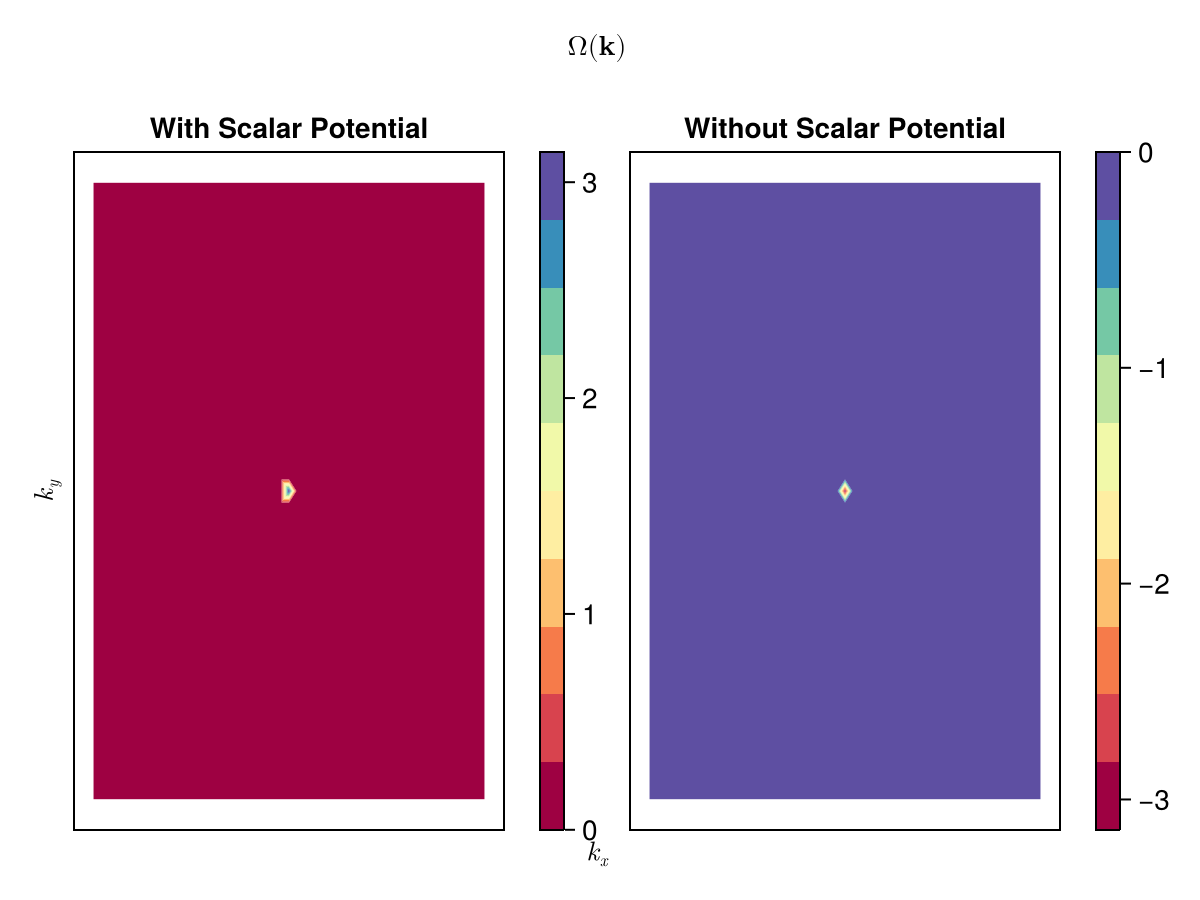

In [126]:
@time begin
    mbz_bi = 7
    uc_bi = 1
    fig = Figure()
        
    t_string = "With Scalar Potential"
    ax = Axis(fig[1, 1], title = t_string)
    hidedecorations!(ax)
    tricontourf!(ax, mbz_kx_avg_list[mbz_bi, :], mbz_ky_avg_list[mbz_bi, :], mbz_flux_list[mbz_bi, :], 
            colormap = :Spectral)
        
    t_string = "Without Scalar Potential"
    ax = Axis(fig[1, 3], title = t_string)
    hidedecorations!(ax)
    tricontourf!(ax, uc_kx_avg_list[uc_bi, :], uc_ky_avg_list[uc_bi, :], uc_flux_list[uc_bi, :], colormap = :Spectral)
    
    X, ax, tr1 = tricontourf(uc_kx_avg_list[uc_bi, :], uc_ky_avg_list[uc_bi, :], uc_flux_list[uc_bi, :], 
            colormap = :Spectral)
    cb = Colorbar(fig[1, 4], tr1)
        
    X, ax, tr2 = tricontourf(mbz_kx_avg_list[mbz_bi, :], mbz_ky_avg_list[mbz_bi, :], mbz_flux_list[mbz_bi, :], 
            colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr2)
        
        
    ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
    hidedecorations!(ax, label = false)
    hidespines!(ax)
    fig
        
    end

<font size="12">Some Debugging</font>

In [97]:
samps = 1000
k_range = range(-2*pi/(q * a), 2*pi/(q * a), samps)
V0 = 10^(-2)

0.010000000000000002

In [98]:
# band structure through ky = 0
Kv_ed_eigenvals = Array{Float64}(undef, samps, 2 * Nl * q^2)
Kv_pt_eigenvals = Array{Float64}(undef, samps, 2 * Nl * q^2)
K_eigenvals = Array{Float64}(undef, samps, 2 * Nl * q^2)
# Scalar potential perturbation
VK = V_r_q2(V0, Nl, q)
for i in 1:samps
    kx = k_range[i]
    # taking the line ky = 0 through mBZ
    ky = 0
    ham = hRG_mBZ(a, uD, t0, t1, t2, t3, t4, Nl, gammas, q, [kx, ky])
    vals = eigvals(ham)
    K_eigenvals[i, :] = real(vals)
    vecs = eigvecs(ham)
    for j in 1:2*Nl*q^2
        Kv_pt_eigenvals[i, j] = real(vals[j]) + real(dot(conj(vecs[:, j]), (VK * vecs[:, j])))
    end
    ham = ham + VK
    vals = eigvals(ham)
    Kv_ed_eigenvals[i, :] = real(vals)
end

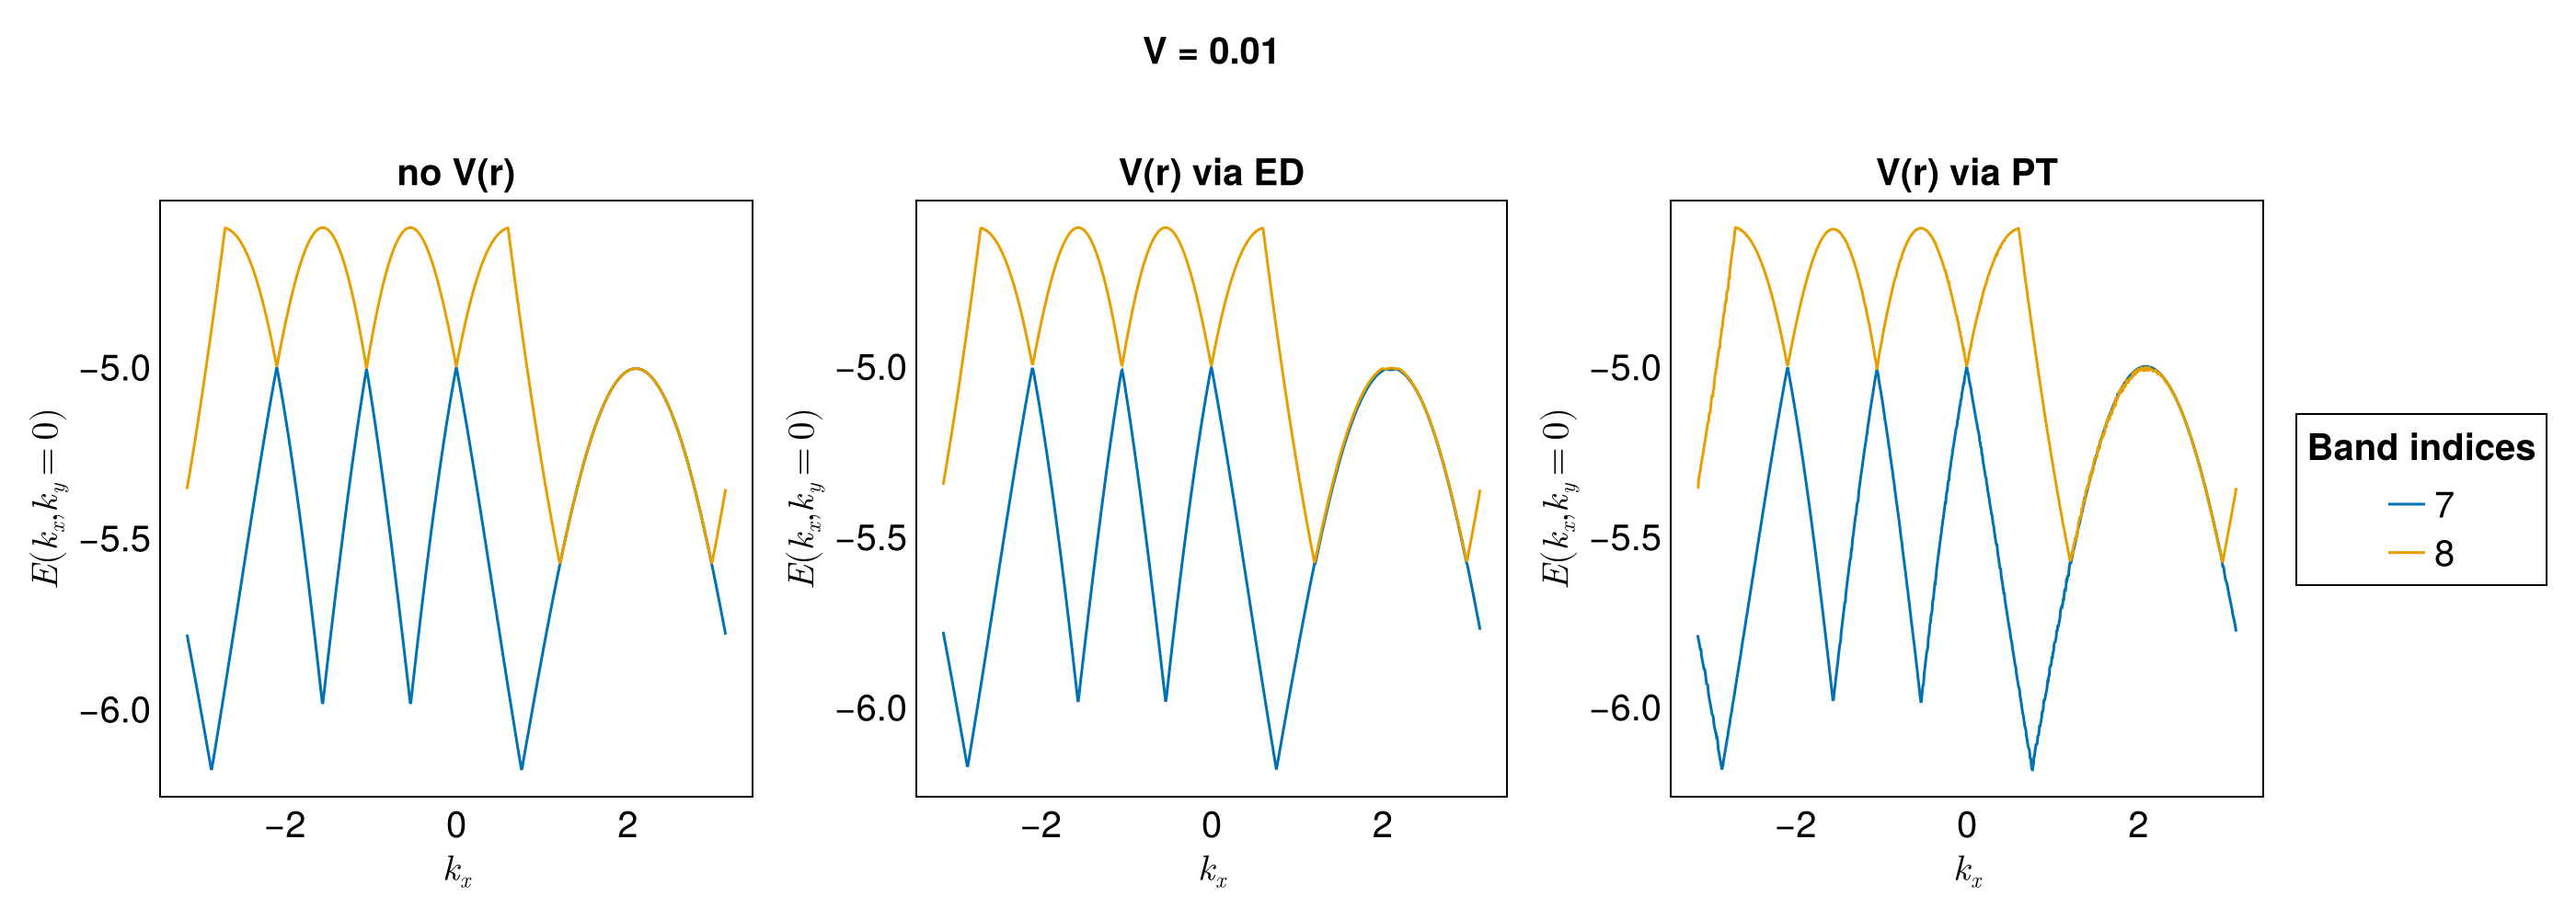

In [99]:
# create plot
P = Figure(size=(1400, 500), fontsize=20)
# create and configure axes
ax_k = Axis(P[1, 1], title = "no V(r)", xlabel = L"k_x", ylabel = L"E(k_x, k_y=0)")
hidedecorations!(ax_k, label = false, ticklabels = false)

ax_kv_ed = Axis(P[1, 2], title = "V(r) via ED", xlabel = L"k_x", ylabel = L"E(k_x, k_y=0)")
hidedecorations!(ax_kv_ed, label = false, ticklabels = false)

ax_kv_pt = Axis(P[1, 3], title = "V(r) via PT", xlabel = L"k_x", ylabel = L"E(k_x, k_y=0)")
hidedecorations!(ax_kv_pt, label = false, ticklabels = false)

ax_major = Axis(P[:, :], title = string("V = ", round(V0, sigdigits = 2)), titlegap = 70)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

# plot bands
for i in 7:8
    lines!(ax_k, k_range, K_eigenvals[:, i], label = string(i))
    lines!(ax_kv_ed, k_range, Kv_ed_eigenvals[:, i], label = string(i))
    lines!(ax_kv_pt, k_range, Kv_pt_eigenvals[:, i], label = string(i))
end

# create and configure legend
P[1, 4] = Legend(P, ax_k, "Band indices", framevisible = true)
P

<font size="12">General mBZ with Scalar Potential</font>


Now we want to do this problem for arbitrarily small mBZ. To this end, we compute the $q^2$ mBZ $\gamma$ points.

In [54]:
# super-lattice factor
q = 2
# potential strength (0.01 is the largest for which PT is valid here)
V0 = 10^(-2)
# pd is point-density
pd = 50
# radius of zone around K point
rad = 0.01
# simplify model
uD = 0
t2 = 0
t3 = 0
t4 = 0
Nl = 3
num_mbz = 4

4

In [55]:
# Redefine these to remind ourselves
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 4*pi/(sqrt(3) * a)]
K = (2/3) * G1 + (1/3) * G2
Kp = (1/3) * G1 + (2/3) * G2

2-element Vector{Float64}:
 2.0943951023931953
 3.6275987284684357

In [56]:
# tiles a BZ centered @ gam with q^2 mBZ's
function find_centers(gam, q, G1, G2)
    # mBZ centers
    gammas = Array{Float64}(undef, q^2, 2)
    counter = 1
    for i in 1:q
        for j in 1:q
            center = gam + (j - 1) * G1/q + (i - 1) * G2/q
            gammas[counter, :] = center
            counter += 1
        end
    end
    return gammas
end

find_centers (generic function with 1 method)

In [57]:
# Make scalar potential in Bloch-basis
function V_r(V_0, Nl, q, num_mbz = q^2)
    V_mat = zeros(2 * Nl * q^2, 2 * Nl * q^2)
    # band index
    for i in 1:2*Nl
        # mBZ index
        for j in 1:(q^2 - 1)
            # connect to q mBZ
            index = i + (j - 1) * (2 * Nl)
            if j <= q * (q - 1)
                V_mat[index, index + q * (2 * Nl)] = V_0
            end
            if j % q != 0
                V_mat[index, index + (2 * Nl)] = V_0
            end
        end
    end
    return (V_mat + adjoint(V_mat))[1:num_mbz*(2*Nl), 1:num_mbz*(2*Nl)]
end

V_r (generic function with 2 methods)

In [58]:
# BZ centered at (0, 0)
gammas = find_centers(K, q, G1, G2)

4×2 Matrix{Float64}:
 4.18879   0.0
 7.33038  -1.8138
 4.18879   3.6276
 7.33038   1.8138

In [59]:
# folded Dirac points
folded_K = Array{Float64}(undef, q^2, 2)
folded_Kp = Array{Float64}(undef, q^2, 2)
for i in 1:q^2
    folded_K[i, :], folded_Kp[i, :] = fold_K(gammas[i, :], q, G1, G2)
end

In [60]:
# Scalar potential perturbation
VK = V_r(V0, Nl, q, num_mbz)

24×24 Matrix{Float64}:
 0.0   0.0   0.0   0.0   0.0   0.0   …  0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0   …  0.0   0.0   0.0   0.0   0.0   0.0
 0.01  0.0   0.0   0.0   0.0   0.0      0.01  0.0   0.0   0.0   0.0   0.0
 0.0   0.01  0.0   0.0   0.0   0.0      0.0   0.01  0.0   0.0   0.0   0.0
 0.0   0.0   0.01  0.0   0.0   0.0      0.0   0.0   0.01  0.0   0.0   0.0
 0.0   0.0   0.0   0.01  0.0   0.0      0.0   0.0   0.0   0.01  0.0   0.0
 0.0   0.0   0.0   0.0   0.01  0.0   …  0.0   0.0   0.0   0.0   0.01  0.0
 0.0   0.0   0.0   0.0   0.0   0.01     0.0   0.0   0.0   0.0   0.0   0.01
 0.01  0.0   0.0   0.0   0.0   0.0      0.01  0.0   0.0   0.0   0.0   0.0
 0.0   0.01  0

In [24]:
# lattices around K points
mBZ_zone = k_zone(folded_K[1, :], pd, rad)
uc_zone = k_zone(K, pd, rad)

LoadError: UndefVarError: `k_zone` not defined

In [62]:
# get berry curvatures
mbz_flux_list = Array{Float64}(undef, 2*Nl*num_mbz, (pd - 1)^2)
mbz_kx_avg_list = Array{Float64}(undef, 2*Nl*num_mbz, (pd - 1)^2)
mbz_ky_avg_list = Array{Float64}(undef, 2*Nl*num_mbz, (pd - 1)^2)

uc_flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_kx_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_ky_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
@time begin
for l in 1:2*Nl*num_mbz
    # with scalar potential
    # only consider 7 mBZ's
    mbz_temp_flux, mbz_akx, mbz_aky = berry_curvature_mBZ(l, mBZ_zone, pd, a, uD, t0, t1, t2, t3, t4, Nl, gammas, VK, q, num_mbz)
    mbz_flux_list[l, :] = mbz_temp_flux
    mbz_kx_avg_list[l, :] = mbz_akx
    mbz_ky_avg_list[l, :] = mbz_aky
    # without scalar potential
    if l <= 2*Nl
        uc_temp_flux, uc_akx, uc_aky = berry_curvature(l, uc_zone, pd, a, uD, t0, t1, t2, t3, t4, Nl)
        uc_flux_list[l, :] = uc_temp_flux
        uc_kx_avg_list[l, :] = uc_akx
        uc_ky_avg_list[l, :] = uc_aky
        end
    end
end

 85.174295 seconds (129.08 M allocations: 112.371 GiB, 7.41% gc time)


  0.256829 seconds (3.35 M allocations: 143.054 MiB, 0.00% compilation time)


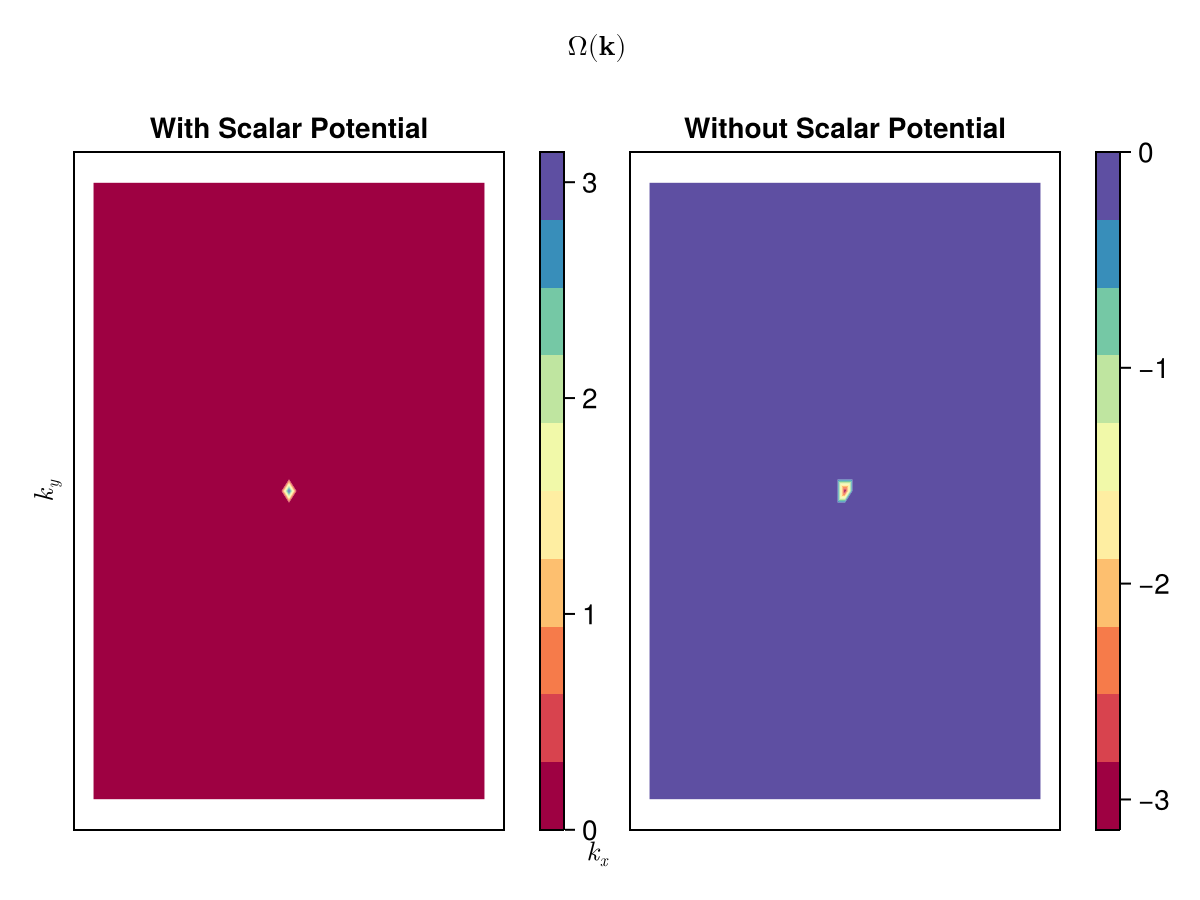

In [63]:
@time begin
    mbz_bi = 7
    uc_bi = 1
    fig = Figure()
        
    t_string = "With Scalar Potential"
    ax = Axis(fig[1, 1], title = t_string)
    hidedecorations!(ax)
    tricontourf!(ax, mbz_kx_avg_list[mbz_bi, :], mbz_ky_avg_list[mbz_bi, :], mbz_flux_list[mbz_bi, :], 
            colormap = :Spectral)
        
    t_string = "Without Scalar Potential"
    ax = Axis(fig[1, 3], title = t_string)
    hidedecorations!(ax)
    tricontourf!(ax, uc_kx_avg_list[uc_bi, :], uc_ky_avg_list[uc_bi, :], uc_flux_list[uc_bi, :], colormap = :Spectral)
    
    X, ax, tr = tricontourf(uc_kx_avg_list[uc_bi, :], uc_ky_avg_list[uc_bi, :], uc_flux_list[uc_bi, :], 
            colormap = :Spectral)
    cb = Colorbar(fig[1, 4], tr)
        
    X, ax, tr = tricontourf(mbz_kx_avg_list[mbz_bi, :], mbz_ky_avg_list[mbz_bi, :], mbz_flux_list[mbz_bi, :], 
            colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr)
        
        
    ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
    hidedecorations!(ax, label = false)
    hidespines!(ax)
    fig
        
    end

<font size="12">General mBZ with Vector Potential FIX!!!</font>

The vector potential we consider is $V(r) = -V_x \sum_{i = 1}^2 cos(\frac{1}{q}G_i \cdot r) \sigma^x -  V_y \sum_{i = 1}^2 cos(\frac{1}{q}G_i \cdot r)\sigma^y$. Here $a^\prime = q * a$ is the super-lattice constant, and $G_i$ are the reciprocal lattice vectors.

In [64]:
# super-lattice factor
q = 2
# potential strength (0.01 is the largest for which PT is valid here)
Vx = 10^(-2)
Vy = 10^(-2)
# pd is point-density
pd = 50
# radius of zone around K point
rad = 0.01
# simplify model
uD = 0
t2 = 0
t3 = 0
t4 = 0
Nl = 3
num_mbz = 4

4

In [65]:
# Redefine these to remind ourselves
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 4*pi/(sqrt(3) * a)]
K = (2/3) * G1 + (1/3) * G2
Kp = (1/3) * G1 + (2/3) * G2

2-element Vector{Float64}:
 2.0943951023931953
 3.6275987284684357

In [66]:
# 2x2 Pauli X
function sigma_x()
    return [0 1; 1 0]
end
# 2x2 Pauli Y
function sigma_y()
    return [0 -im; im 0]
end
# 2x2 Pauli Z
function sigma_z()
    return [1 0; 0 -1]
end

sigma_z (generic function with 1 method)

In [67]:
function V_temp(V_0, Nl, q)
    V_mat = zeros(Nl * q^2, Nl * q^2)
    # band index
    for i in 1:Nl
        # mBZ index
        for j in 1:(q^2 - 1)
            # connect to q mBZ
            index = i + (j - 1) * Nl
            if j <= q * (q - 1)
                V_mat[index, index + q * Nl] = V_0
            end
            if j % q != 0
                V_mat[index, index + Nl] = V_0
            end
        end
    end
    return V_mat + adjoint(V_mat)
end

V_temp (generic function with 1 method)

In [68]:
# Make vector potential in Bloch-basis
function V_r_vector(Vx, Vy, Nl, q, num_mbz = q^2)
    # in-plane vector potential
    Vx_mat = V_temp(Vx, Nl, q)
    Vy_mat = V_temp(Vy, Nl, q)
    V_fin = kron(Vx_mat, sigma_x()) + kron(Vy_mat, sigma_y())
    return V_fin[1:num_mbz*(2*Nl), 1:num_mbz*(2*Nl)]
end

V_r_vector (generic function with 2 methods)

In [69]:
# BZ centered at (0, 0)
gammas = find_centers(K, q, G1, G2)

4×2 Matrix{Float64}:
 4.18879   0.0
 7.33038  -1.8138
 4.18879   3.6276
 7.33038   1.8138

In [70]:
# folded Dirac points
folded_K = Array{Float64}(undef, q^2, 2)
folded_Kp = Array{Float64}(undef, q^2, 2)
for i in 1:q^2
    folded_K[i, :], folded_Kp[i, :] = fold_K(gammas[i, :], q, G1, G2)
end

In [71]:
# Scalar potential perturbation
VK = V_r_vector(Vx, Vy, Nl, q, num_mbz)

24×24 Matrix{ComplexF64}:
  0.0+0.0im    0.0-0.0im    0.0+0.0im   …   0.0+0.0im    0.0-0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im       0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0-0.0im    0.0+0.0im       0.0+0.0im    0.0-0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im       0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0-0.0im    0.0+0.0im       0.0+0.0im    0.0-0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im   …   0.0+0.0im    0.0+0.0im
  0.0+0.0im   0.01-0.01im   0.0+0.0im       0.0+0.0im    0.0-0.0im
 0.01+0.01im   0.0+0.0im    0.0+0.0im       0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0-0.0im    0.0+0.0im       0.0+0.0im    0.0-0.0im
  0.0+0.0im    0.0+0.0im   0.01+0.01im      0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0-0.0im    0.0+0.0im   …   0.0+0.0im   0.01-0.01im
  0.0+0.0im    0.0+0.0im    0.0+0.0im      0.01+0.01im   0.0+0.0im
  0.0+0.0im   0.01-0.01im   0.0+0.0im       0.0+0.0im    0.0-0.0im
 0.01+0.01im   0.0+0.0im    0.0+0.0im       0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0-0.0im    0.0+0.0

In [72]:
# lattices around K points
mBZ_zone = k_zone(folded_K[1, :], pd, rad)
uc_zone = k_zone(K, pd, rad)

50×50×2 Array{Float64, 3}:
[:, :, 1] =
 4.18379  4.18379  4.18379  4.18379  …  4.18379  4.18379  4.18379  4.18379
 4.18399  4.18399  4.18399  4.18399     4.18399  4.18399  4.18399  4.18399
 4.1842   4.1842   4.1842   4.1842      4.1842   4.1842   4.1842   4.1842
 4.1844   4.1844   4.1844   4.1844      4.1844   4.1844   4.1844   4.1844
 4.18461  4.18461  4.18461  4.18461     4.18461  4.18461  4.18461  4.18461
 4.18481  4.18481  4.18481  4.18481  …  4.18481  4.18481  4.18481  4.18481
 4.18501  4.18501  4.18501  4.18501     4.18501  4.18501  4.18501  4.18501
 4.18522  4.18522  4.18522  4.18522     4.18522  4.18522  4.18522  4.18522
 4.18542  4.18542  4.18542  4.18542     4.18542  4.18542  4.18542  4.18542
 4.18563  4.18563  4.18563  4.18563     4.18563  4.18563  4.18563  4.18563
 4.18583  4.18583  4.18583  4.18583  …  4.18583  4.18583  4.18583  4.18583
 4.18604  4.18604  4.18604  4.18604     4.18604  4.18604  4.18604  4.18604
 4.18624  4.18624  4.18624  4.18624     4.18624  4.18624  4.186

In [73]:
# get berry curvatures
mbz_flux_list = Array{Float64}(undef, 2*Nl*num_mbz, (pd - 1)^2)
mbz_kx_avg_list = Array{Float64}(undef, 2*Nl*num_mbz, (pd - 1)^2)
mbz_ky_avg_list = Array{Float64}(undef, 2*Nl*num_mbz, (pd - 1)^2)

uc_flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_kx_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_ky_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
@time begin
for l in 1:2*Nl*num_mbz
    # with vector potential
    # only consider 7 mBZ's
    mbz_temp_flux, mbz_akx, mbz_aky = berry_curvature_mBZ(l, mBZ_zone, pd, a, uD, t0, t1, t2, t3, t4, Nl, gammas, VK, q, num_mbz)
    mbz_flux_list[l, :] = mbz_temp_flux
    mbz_kx_avg_list[l, :] = mbz_akx
    mbz_ky_avg_list[l, :] = mbz_aky
    # without vector potential
    if l <= 2*Nl
        uc_temp_flux, uc_akx, uc_aky = berry_curvature(l, uc_zone, pd, a, uD, t0, t1, t2, t3, t4, Nl)
        uc_flux_list[l, :] = uc_temp_flux
        uc_kx_avg_list[l, :] = uc_akx
        uc_ky_avg_list[l, :] = uc_aky
        end
    end
end

 63.831829 seconds (129.27 M allocations: 112.384 GiB, 9.17% gc time, 0.17% compilation time)


  0.260735 seconds (3.37 M allocations: 143.682 MiB, 0.00% compilation time)


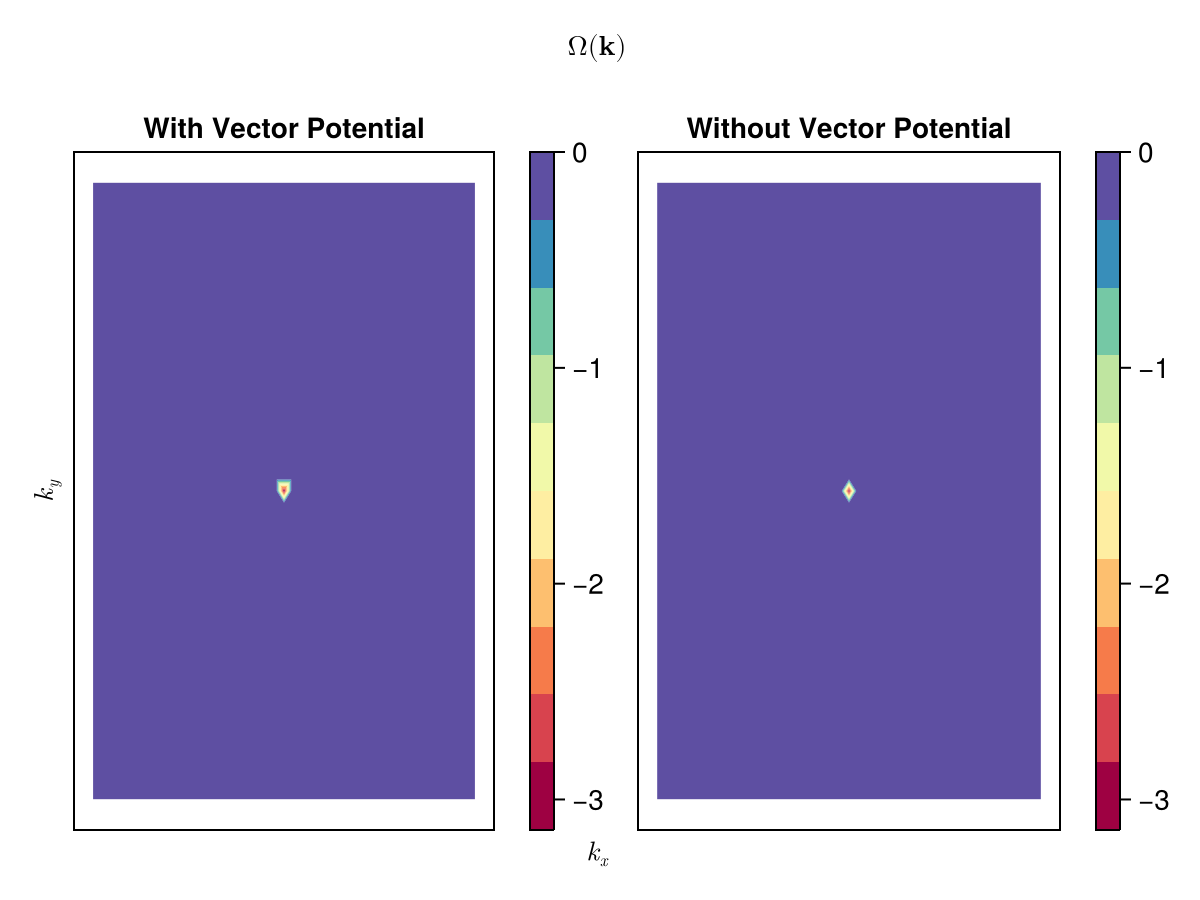

In [74]:
@time begin
    mbz_bi = 7
    uc_bi = 1
    fig = Figure()
        
    t_string = "With Vector Potential"
    ax = Axis(fig[1, 1], title = t_string)
    hidedecorations!(ax)
    tricontourf!(ax, mbz_kx_avg_list[mbz_bi, :], mbz_ky_avg_list[mbz_bi, :], mbz_flux_list[mbz_bi, :], 
            colormap = :Spectral)
        
    t_string = "Without Vector Potential"
    ax = Axis(fig[1, 3], title = t_string)
    hidedecorations!(ax)
    tricontourf!(ax, uc_kx_avg_list[uc_bi, :], uc_ky_avg_list[uc_bi, :], uc_flux_list[uc_bi, :], colormap = :Spectral)
    
    X, ax, tr = tricontourf(uc_kx_avg_list[uc_bi, :], uc_ky_avg_list[uc_bi, :], uc_flux_list[uc_bi, :], 
            colormap = :Spectral)
    cb = Colorbar(fig[1, 4], tr)
        
    X, ax, tr = tricontourf(mbz_kx_avg_list[mbz_bi, :], mbz_ky_avg_list[mbz_bi, :], mbz_flux_list[mbz_bi, :], 
            colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr)
        
        
    ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
    hidedecorations!(ax, label = false)
    hidespines!(ax)
    fig
        
    end

<font size="12">Infinite N Limit</font>

In [381]:
a = 1
uD = 1
t0 = 100
t1 = 10^(-8)
t2 = 0
t3 = 0
t4 = 0
Nl = 80

80

In [382]:
samps = 1000
k_range = range(-2*pi/a, 2*pi/a, samps)

-6.283185307179586:0.012578949563923095:6.283185307179586

In [383]:
# Want to get dispersions around K point
K_eigenvals = Array{Float64}(undef, samps, 2 * Nl)
for i in 1:samps
    kx = k_range[i]
    ky = K[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    K_eigenvals[i, :] = real(vals)
end

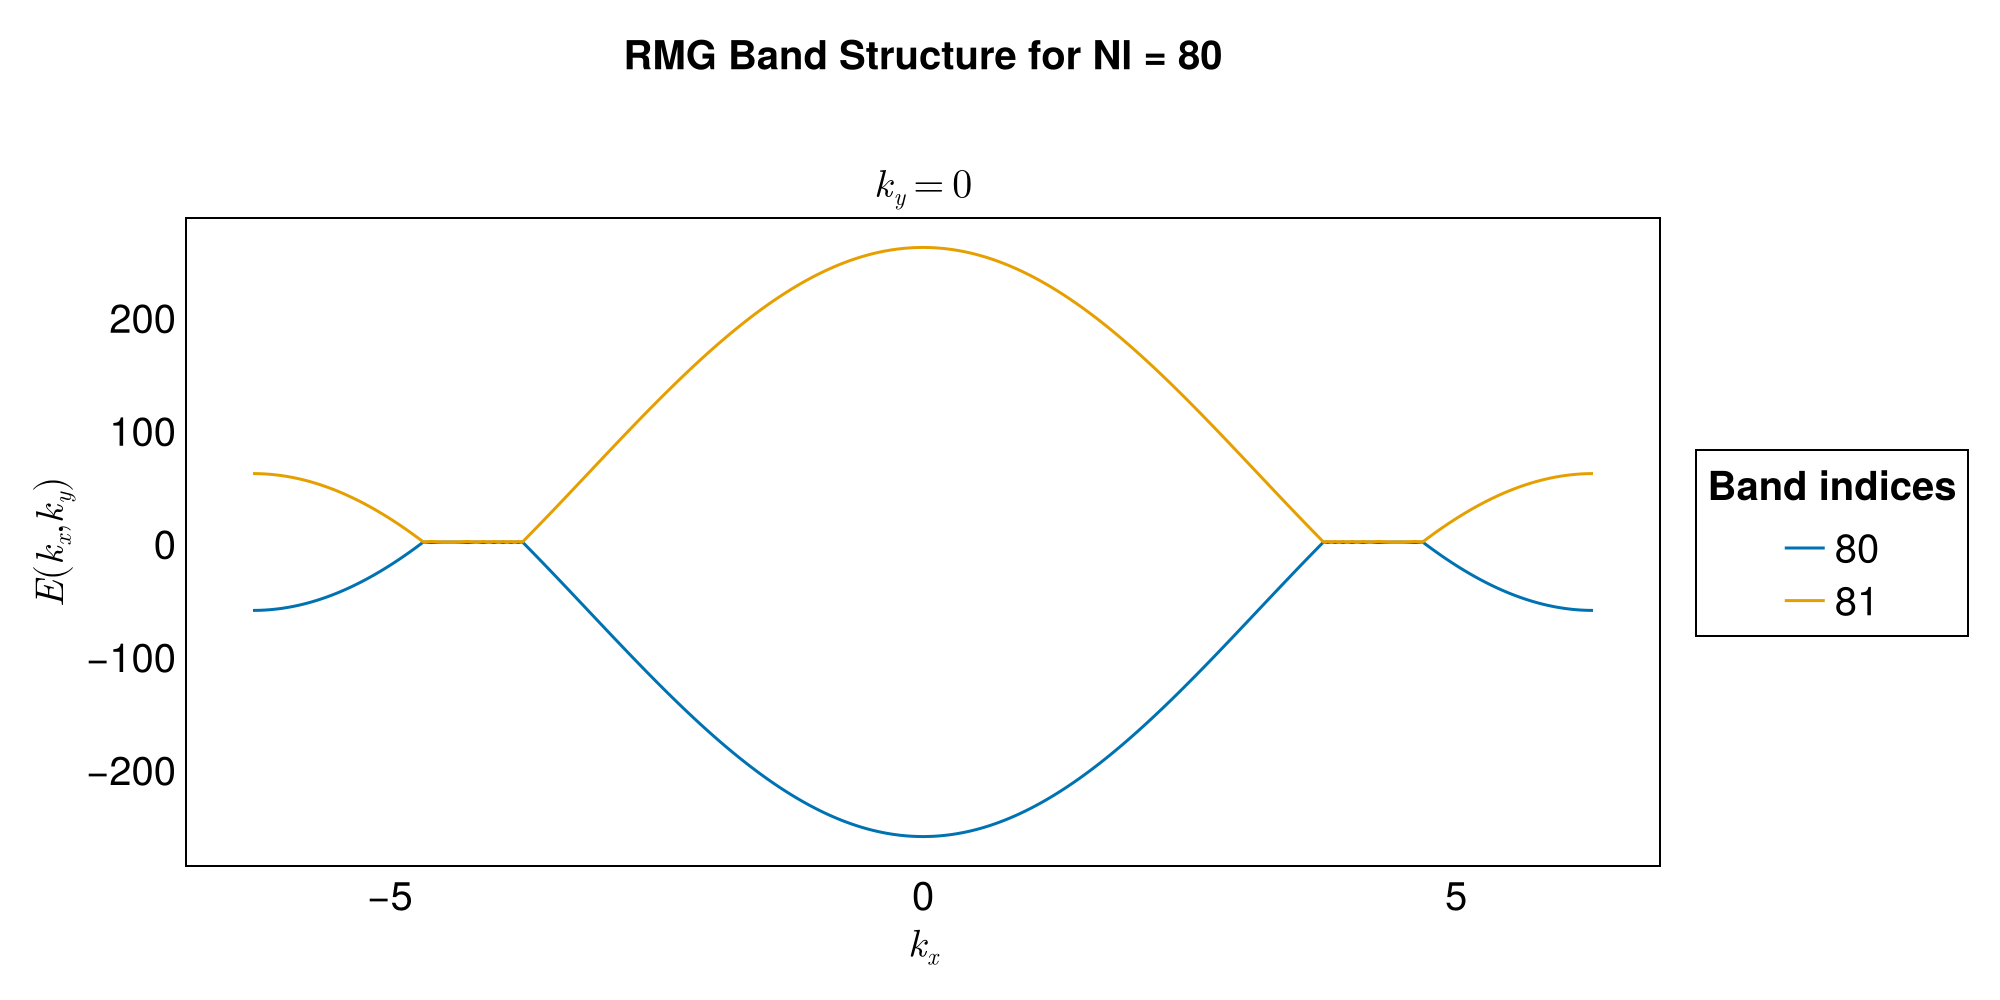

In [384]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax_k = Axis(P[1, 1], title = L"k_y = 0", xlabel = L"k_x", ylabel = L"E(k_x, k_y)")
hidedecorations!(ax_k, label = false, ticklabels = false)
ax_major = Axis(P[:, :], title = string("RMG Band Structure for Nl = ", string(Nl)), titlegap = 70)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

# plot bands
for i in Nl:(Nl+1)
    lines!(ax_k, k_range, K_eigenvals[:, i], label = string(i))
end
# create and configure legend
P[1, 2] = Legend(P, ax_k, "Band indices", framevisible = true)
P

<font size="12">Infinite N Limit Perturbatively</font>

In [366]:
a = 1
uD = 1
t0 = 100
t1 = 10^(-8)
t2 = 0
t3 = 0
t4 = 0
Nl = 150

150

In [367]:
samps = 1000
k_range = range(-2*pi/a, 2*pi/a, samps)

-6.283185307179586:0.012578949563923095:6.283185307179586

In [368]:
# Want to get dispersions around K point
K_eigenvals = Array{Float64}(undef, samps, 2 * Nl)
K_eigenvecs0 = Array{Float64}(undef, samps, 2 * Nl, 2 * Nl)
for i in 1:samps
    kx = k_range[i]
    ky = K[2]
    ham = hRG(a, uD, t0, 0, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    vecs = eigvecs(ham)
    K_eigenvals[i, :] = real(vals)
    K_eigenvecs0[i, :, :] = vecs
end

In [369]:
H_t1 = hRG(a, 0, 0, t1, 0, 0, 0, Nl, [0, 0])

300×300 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                        
 0.0+0.0im  0.0

In [370]:
K_eigenvecs1 = Array{Float64}(undef, samps, 2 * Nl, 2 * Nl)
# look at bands Nl, Nl + 1
for j in 1:samps
    Nlv = K_eigenvecs0[j, :, Nl]
    ev = K_eigenvals[j, Nl]
    Nlv1 = K_eigenvecs0[j, :, Nl + 1]
    ev1 = K_eigenvals[j, Nl + 1]

    Nlvec = Nlv
    Nlvec1 = Nlv1
    for i in 1:2*Nl
        kvec = K_eigenvecs0[j, :, i]
        kev = K_eigenvals[j, i]
        if i != Nl
            correction = dot(kvec, (H_t1 * Nlv)) / (ev - kev)
            Nlvec += correction * kvec
        end
        if i != Nl + 1
            correction = dot(kvec, (H_t1 * Nlv1)) / (ev1 - kev)
            Nlvec1 += correction * kvec
        end
    end
    K_eigenvecs1[j, Nl, :] = Nlvec
    K_eigenvecs1[j, Nl + 1, :] = Nlvec1
end

In [371]:
K_eigenvals1 = Array{Float64}(undef, samps, 2 * Nl)
for j in 1:samps
    vNl = K_eigenvecs1[j, Nl, :]
    vNl1 = K_eigenvecs1[j, Nl + 1, :]
    K_eigenvals1[j, Nl] = K_eigenvals[j, Nl] + dot(vNl, (H_t1 * vNl))
    K_eigenvals1[j, Nl + 1] = K_eigenvals[j, Nl + 1] + dot(vNl1, (H_t1 * vNl1))
end

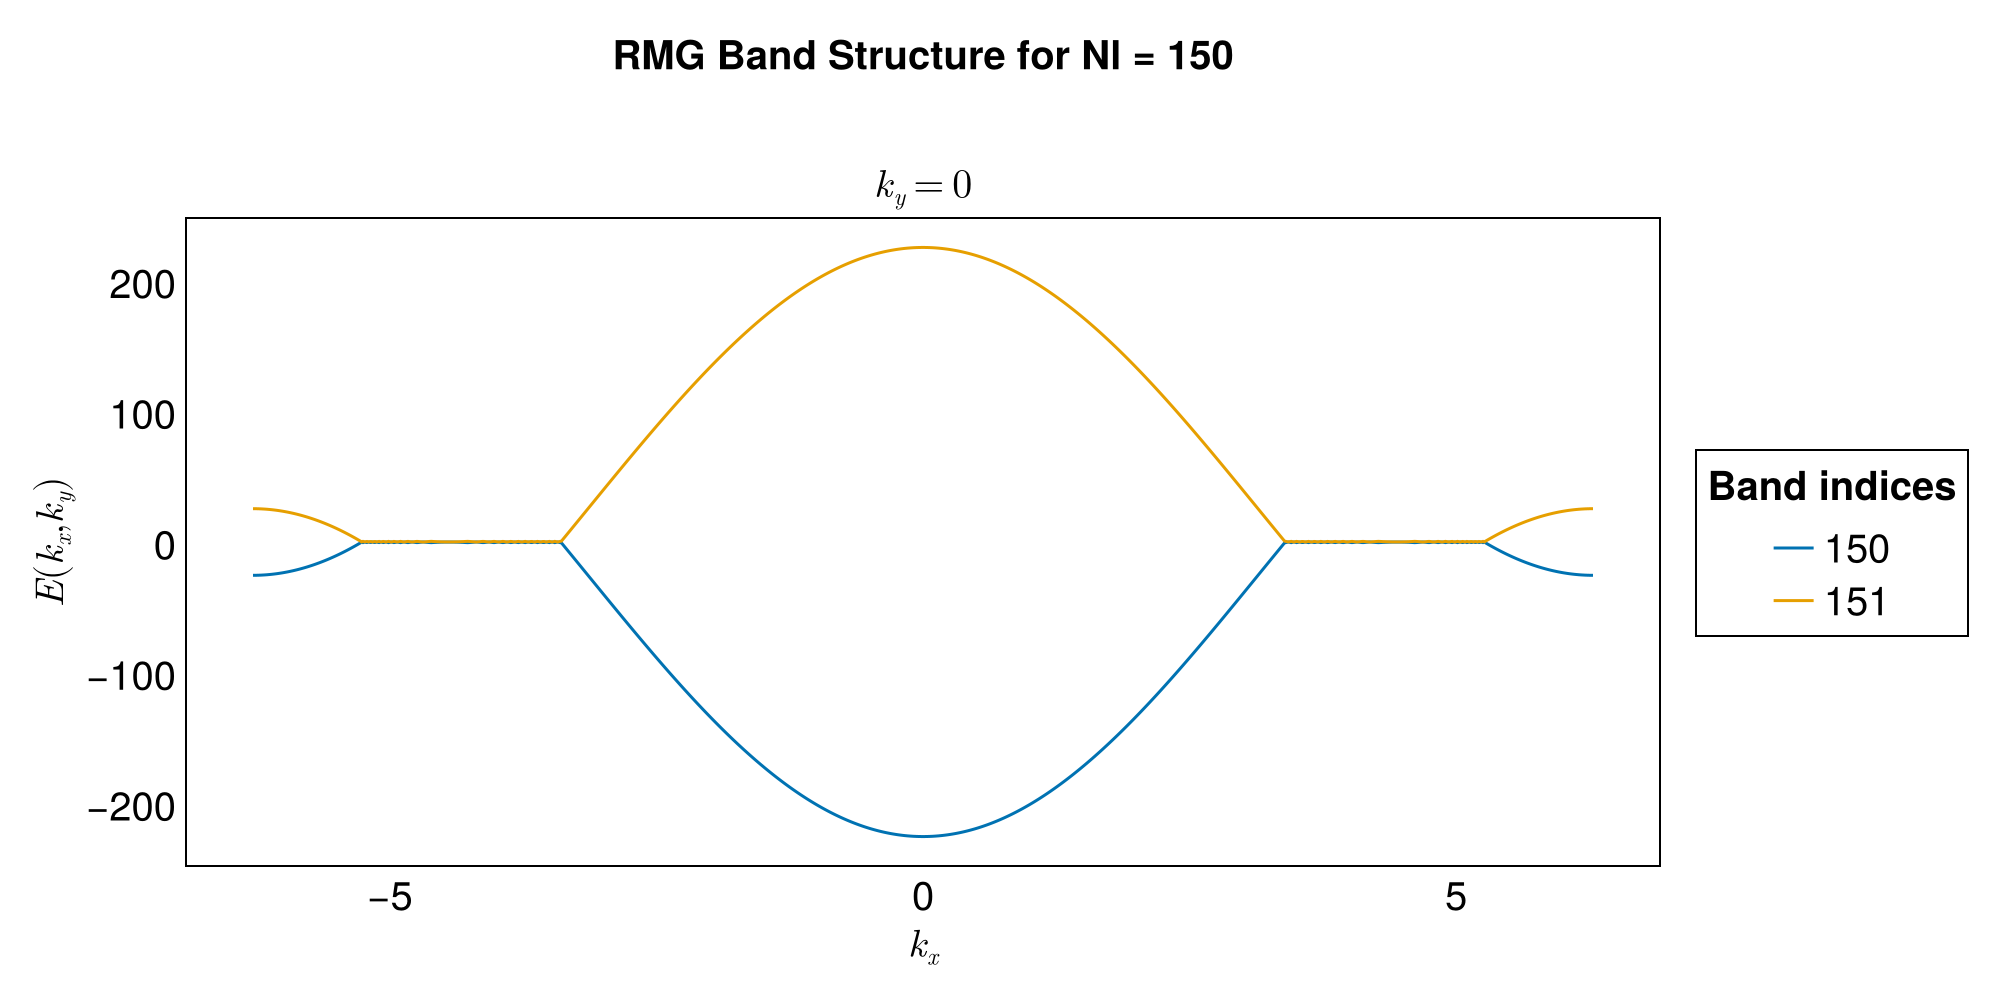

In [372]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax_k = Axis(P[1, 1], title = L"k_y = 0", xlabel = L"k_x", ylabel = L"E(k_x, k_y)")
hidedecorations!(ax_k, label = false, ticklabels = false)
ax_major = Axis(P[:, :], title = string("RMG Band Structure for Nl = ", string(Nl)), titlegap = 70)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

# plot bands
for i in Nl:(Nl+1)
    lines!(ax_k, k_range, K_eigenvals1[:, i], label = string(i))
end
# create and configure legend
P[1, 2] = Legend(P, ax_k, "Band indices", framevisible = true)
P

<font size="12">Checks</font>

In [432]:
a = 1
uD = 1
t0 = 100
t1 = 10^(-8)
t2 = 0
t3 = 0
t4 = 0
Nl = 3

3

In [433]:
print(K_eigenvals[1, Nl])

-97.0

In [437]:
eg = uAB(uD, Nl, Nl) + t0 * f([k_range[1], K[2]], a)
print(eg)

-97.0 + 0.0im

In [427]:
samps = 2
k_range = range(-2*pi/a, 2*pi/a, samps)

-6.283185307179586:12.566370614359172:6.283185307179586

In [428]:
# Want to get dispersions around K point
K_eigenvals = Array{Float64}(undef, samps, 2 * Nl)
K_eigenvecs0 = Array{Float64}(undef, samps, 2 * Nl, 2 * Nl)
for i in 1:samps
    kx = k_range[i]
    ky = K[2]
    ham = hRG(a, uD, t0, 0, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    vecs = eigvecs(ham)
    K_eigenvals[i, :] = real(vals)
    K_eigenvecs0[i, :, :] = vecs
end

In [429]:
H_t1 = hRG(a, 0, 0, t1, 0, 0, 0, Nl, [0, 0])

6×6 Matrix{ComplexF64}:
 0.0+0.0im     0.0+0.0im     0.0+0.0im     0.0+0.0im     0.0+0.0im  0.0+0.0im
 0.0+0.0im     0.0+0.0im     0.0+0.0im  1.0e-8+0.0im     0.0+0.0im  0.0+0.0im
 0.0+0.0im     0.0+0.0im     0.0+0.0im     0.0+0.0im  1.0e-8+0.0im  0.0+0.0im
 0.0+0.0im  1.0e-8+0.0im     0.0+0.0im     0.0+0.0im     0.0+0.0im  0.0+0.0im
 0.0+0.0im     0.0+0.0im  1.0e-8+0.0im     0.0+0.0im     0.0+0.0im  0.0+0.0im
 0.0+0.0im     0.0+0.0im     0.0+0.0im     0.0+0.0im     0.0+0.0im  0.0+0.0im

In [449]:
println(dot(K_eigenvecs0[1, 2 * Nl - 1, :], H_t1 * K_eigenvecs0[1, Nl, :]))

-5.000000000000001e-9 + 0.0im


In [450]:
println(0.5 * (-t1 * f([k_range[1], K[2]], a) / abs(f([k_range[1], K[2]], a))))

5.0e-9 - 0.0im


In [458]:
print(K_eigenvals[1, Nl] - K_eigenvals[1, Nl - 1])

0.9999999999999858

In [457]:
print(uD)

100.0

In [440]:
K_eigenvecs1 = Array{Float64}(undef, samps, 2 * Nl, 2 * Nl)
# look at bands Nl, Nl + 1
for j in 1:1
    Nlv = K_eigenvecs0[j, :, Nl]
    ev = K_eigenvals[j, Nl]
    Nlv1 = K_eigenvecs0[j, :, Nl + 1]
    ev1 = K_eigenvals[j, Nl + 1]

    Nlvec = Nlv
    Nlvec1 = Nlv1
    for i in 1:2*Nl
        kvec = K_eigenvecs0[j, :, i]
        kev = K_eigenvals[j, i]
        if i != Nl
            correction = dot(kvec, (H_t1 * Nlv)) / (ev - kev)
            if correction != 0
                println(i)
            end
            Nlvec += correction * kvec
        end
        if i != Nl + 1
            correction = dot(kvec, (H_t1 * Nlv1)) / (ev1 - kev)
            Nlvec1 += correction * kvec
        end
    end
    K_eigenvecs1[j, Nl, :] = Nlvec
    K_eigenvecs1[j, Nl + 1, :] = Nlvec1
end

2
5
